In [224]:
# %load jupyter_default.py
import pandas as pd
import numpy as np
import os
import re
import datetime
import time
import glob
from tqdm import tqdm_notebook
from colorama import Fore, Style

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns

%config InlineBackend.figure_format='retina'
sns.set() # Revert to matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelpad'] = 20
plt.rcParams['legend.fancybox'] = True
plt.style.use('ggplot')

SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 14, 16, 20
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=SMALL_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=MEDIUM_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)

def savefig(plt, name):
    plt.savefig(f'../../figures/{name}.png', bbox_inches='tight', dpi=300)

%load_ext version_information
%version_information pandas, numpy

The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software versions
Python 3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 7.2.0
OS Darwin 18.2.0 x86_64 i386 64bit
pandas 0.23.4
numpy 1.15.4
Sat Mar 09 15:16:39 2019 PST

## Bayesian Modeling Discussion

We can model the probability of an outcome $y$ as $P_t(y)$ using a discrete **Poisson distribution** i.e. if discretizing the time $t$ in seconds.

$$
P_t(\mu) = \frac{\mu^te^{-\mu}}{k!}
$$

Instead we could also assume a Gamma posterior, which has the advantage of being continuous and has more parameters than can be optimized. For now we'll stick with using the simpler Poisson distribution.

Based on a set of goalie pull observations $X$ from 2003-2007 NHL games, we'll solve for the posterior distribution $P_t(y|X)$, the probability of the outcome $y$, given the observations. This is done computationally using markov chain monte carlo and the `pymc3` library.

The outcomes we're interested in are $y = \big\{\mathrm{goal\;for}, \mathrm{goal\;against}, \mathrm{no\;goal}\big\}$. 

We'll use a **uniform prior** over the domain of times (last 5mins). Note: when gathering the observations, we throw out goalie pulls greater than 5 minutes from the end of the game (due to high likelihood of false positives when parsing goalie pulls from the raw game table).

Once we find the posteriors discussed above, we can study the risk reward of pulling a goalie. We'll compare posteriors to find the odds of scoring a goal (and the odds of getting scored on) over time $t$ where:
 - **t = Time remaining in the game** e.g. if there's 3 minutes left, what is the chance that pulling the goalie will result in a goal for?
 - **t = Time since goalie pull** e.g. after the goalie has been pulled for 1 minute, what is the chance of getting a goal?

In [226]:
import pymc3 as pm

### Load the training data

In [243]:
ls ../../data/processed/pkl/

20032004_goalie_pulls_2019-03-01.pkl  20062007_goalie_pulls_2019-03-01.pkl
20052006_goalie_pulls_2019-03-01.pkl


In [227]:
def load_data():
    files = glob.glob('../../data/processed/pkl/*.pkl')
    files = sorted(files)
    print(files)
    return pd.concat((pd.read_pickle(f) for f in files))

def clean_df(df):
    _df = df.copy()
    
    len_0 = _df.shape[0]
    print('Removing goal_for_time < 15 mins')
    _df = _df[~(_df.goal_for_time < datetime.timedelta(seconds=15*60))]
    print(f'Removed {len_0 - _df.shape[0]} total rows')
    
    if 'game_end_time' in df.columns:
        len_0 = _df.shape[0]
        print('Removing game_end_time < 15 mins')
        _df = _df[~(_df.game_end_time < datetime.timedelta(seconds=60*15))]
        print(f'Removed {len_0 - _df.shape[0]} total rows')

    return _df

In [228]:
df = load_data()
df = clean_df(df)

['../../data/processed/pkl/20032004_goalie_pulls_2019-03-01.pkl', '../../data/processed/pkl/20052006_goalie_pulls_2019-03-01.pkl', '../../data/processed/pkl/20062007_goalie_pulls_2019-03-01.pkl']
Removing goal_for_time < 15 mins
Removed 1 total rows


In [230]:
def load_training_samples(
    df,
    cols,
    masks=[],
    dtype='timedelta64[s]'
) -> np.ndarray:
    '''
    Return buckets of training data.
    '''
    if not masks:
        masks = [None] * len(cols)
    out = []
    for col, m in zip(cols, masks):
        if m is None:
            d = df[col].dropna().astype(dtype).values
        else:
            d = df[col][m].dropna().astype(dtype).values
        out.append(d)
        print(f'Loaded {len(d)} samples for col {col}')

    out = np.array(out)
    print(f'Training data shape = {out.shape}')
    return out

In [231]:
# Load time of pull for eventual outcomes:
feature_names = ['goal_for', 'goal_against', 'no_goals']

# Logic for loading the data
features = ['pull_time', 'pull_time', 'pull_time']
masks = [
    ~(df.goal_for_time.isnull()),
    ~(df.goal_against_time.isnull()),
    (df.goal_for_time.isnull() & df.goal_against_time.isnull()),
]
training_samples = load_training_samples(df, features, masks)

Loaded 270 samples for col pull_time
Loaded 554 samples for col pull_time
Loaded 1305 samples for col pull_time
Training data shape = (3,)


In [232]:
(training_samples[0][:10],
training_samples[1][:10],
training_samples[2][:10],)

(array([1119., 1114., 1109., 1111., 1081., 1121., 1100., 1103., 1145.,
        1142.]),
 array([1184., 1143., 1168., 1133., 1133., 1140., 1118., 1130., 1148.,
        1104.]),
 array([1198., 1125., 1068., 1151., 1119., 1137., 1131., 1140., 1192.,
        1137.]))

## Modeling

In [242]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Model() as model:

        # Priors for the mu parameter of the
        # Poisson distribution P.
        # Note: mu = mean(P)
        mu_goal_for = pm.Uniform(
            'mu_goal_for', 15*60, 20*60
        )
        mu_goal_against = pm.Uniform(
            'mu_goal_against', 15*60, 20*60
        )
        mu_no_goal = pm.Uniform(
            'mu_no_goal', 15*60, 20*60
        )
        
        # Observations to train the model on
        obs_goal_for = pm.Poisson(
            'obs_goal_for',
            mu=mu_goal_for,
            observed=training_samples[0],
        )
        obs_goal_against = pm.Poisson(
            'obs_goal_against',
            mu=mu_goal_against,
            observed=training_samples[1],
        )
        obs_no_goal = pm.Poisson(
            'obs_no_goal',
            mu=mu_no_goal,
            observed=training_samples[2],
        )
        
        # Outcome probabilities
        p_goal_for = pm.Bound(pm.Poisson, upper=20*60)('p_goal_for', mu=mu_goal_for)
        p_goal_against = pm.Bound(pm.Poisson, upper=20*60)('p_goal_against', mu=mu_goal_against)
        p_no_goal = pm.Bound(pm.Poisson, upper=20*60)('p_no_goal', mu=mu_no_goal)
        
        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_no_goal]
>Metropolis: [p_goal_against]
>Metropolis: [p_goal_for]
>Metropolis: [mu_no_goal]
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:27<00:00, 2726.88draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [244]:
N_burn = 10000
burned_trace = trace[N_burn:]

In [310]:
from typing import Tuple

from scipy.stats import poisson

def poisson_posterior(burned_trace) -> Tuple[np.ndarray]:
    p = poisson.pmf
    x = np.arange(15*60, 20*60, 1)

    mu_goal_for = burned_trace['mu_goal_for'].mean()
    mu_goal_against = burned_trace['mu_goal_against'].mean()
    mu_no_goal = burned_trace['mu_no_goal'].mean()

    y_goal_for = p(x, mu_goal_for)
    y_goal_against = p(x, mu_goal_against)
    y_no_goal = p(x, mu_no_goal)
    
    # Convert into minutes
    x = x / 60

    return x, y_goal_for, y_goal_against, y_no_goal


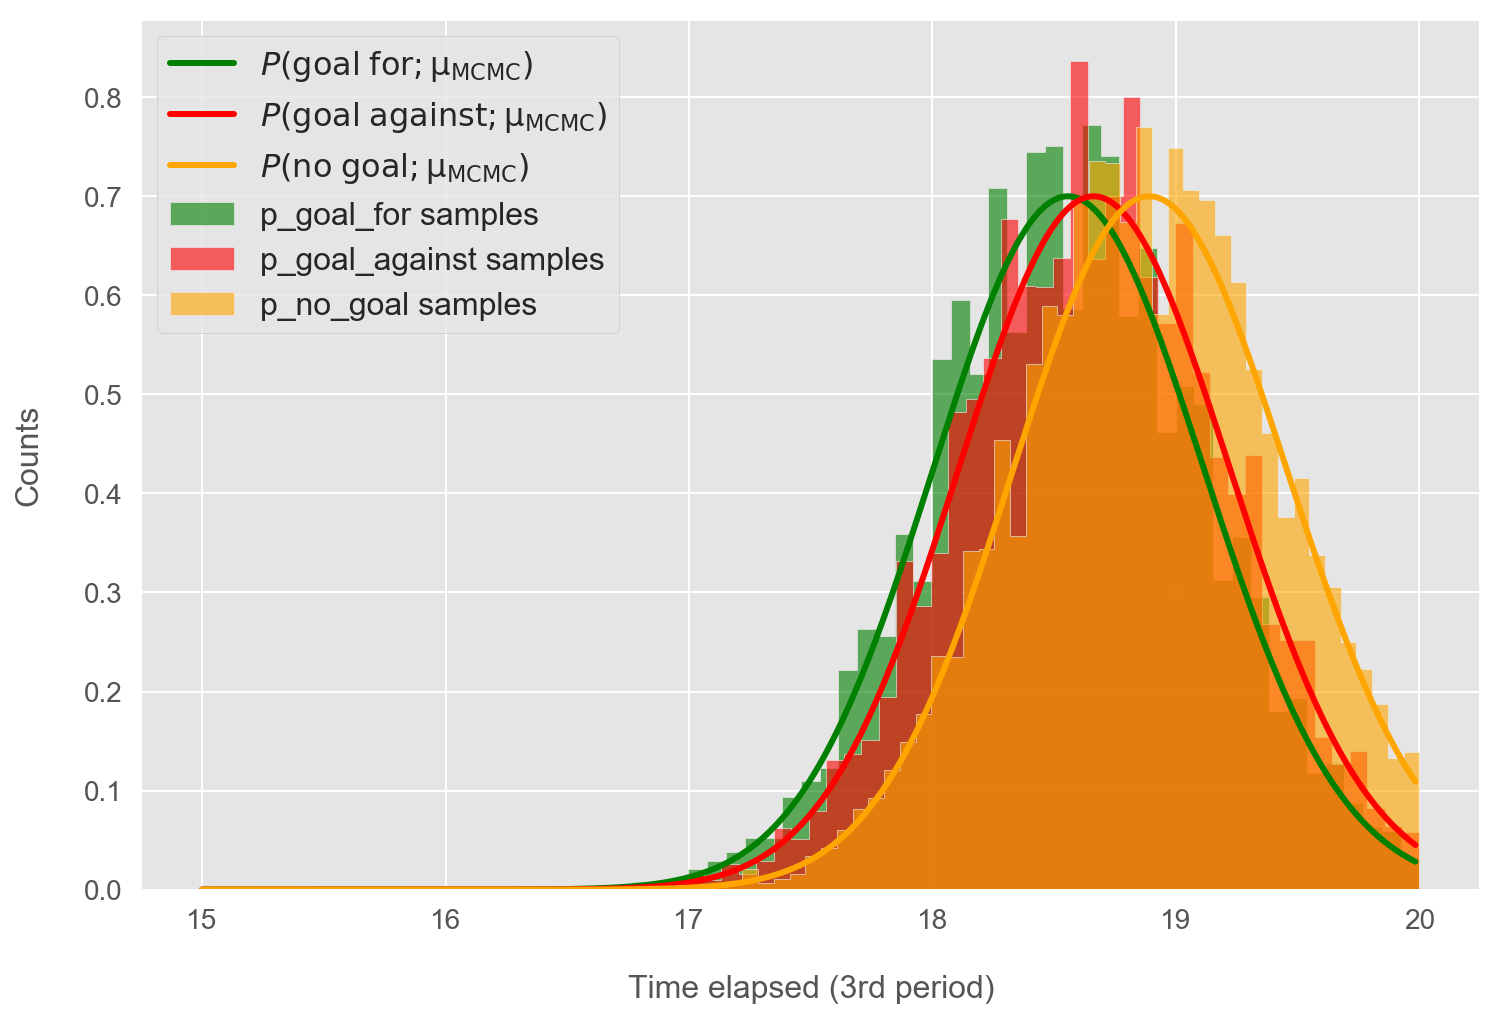

In [311]:
ALPHA = 0.6
LW = 3

''' Plot MCMC samples '''

plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
         color='green', label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
         color='red', label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_no_goal'] / 60, bins=50,
         color='orange', label='p_no_goal samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

''' Plot poisson distributions '''
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(burned_trace)

# Rescale
scale_frac = 0.7
y_goal_for = y_goal_for / y_goal_for.max() * scale_frac
y_goal_against = y_goal_against / y_goal_against.max() * scale_frac
y_no_goal = y_no_goal / y_no_goal.max() * scale_frac

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{MCMC})$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{MCMC})$', color='red', lw=LW)
plt.plot(x, y_no_goal, label=r'$P(\rm{no\;goal};\mu_{MCMC})$', color='orange', lw=LW)

''' Clean up the chart '''

plt.ylabel('Counts')
# plt.yticks([])
plt.xlabel('Time elapsed (3rd period)')
plt.legend()

savefig(plt, 'time_elapsed_poisson_mcmc_samples')

plt.show()

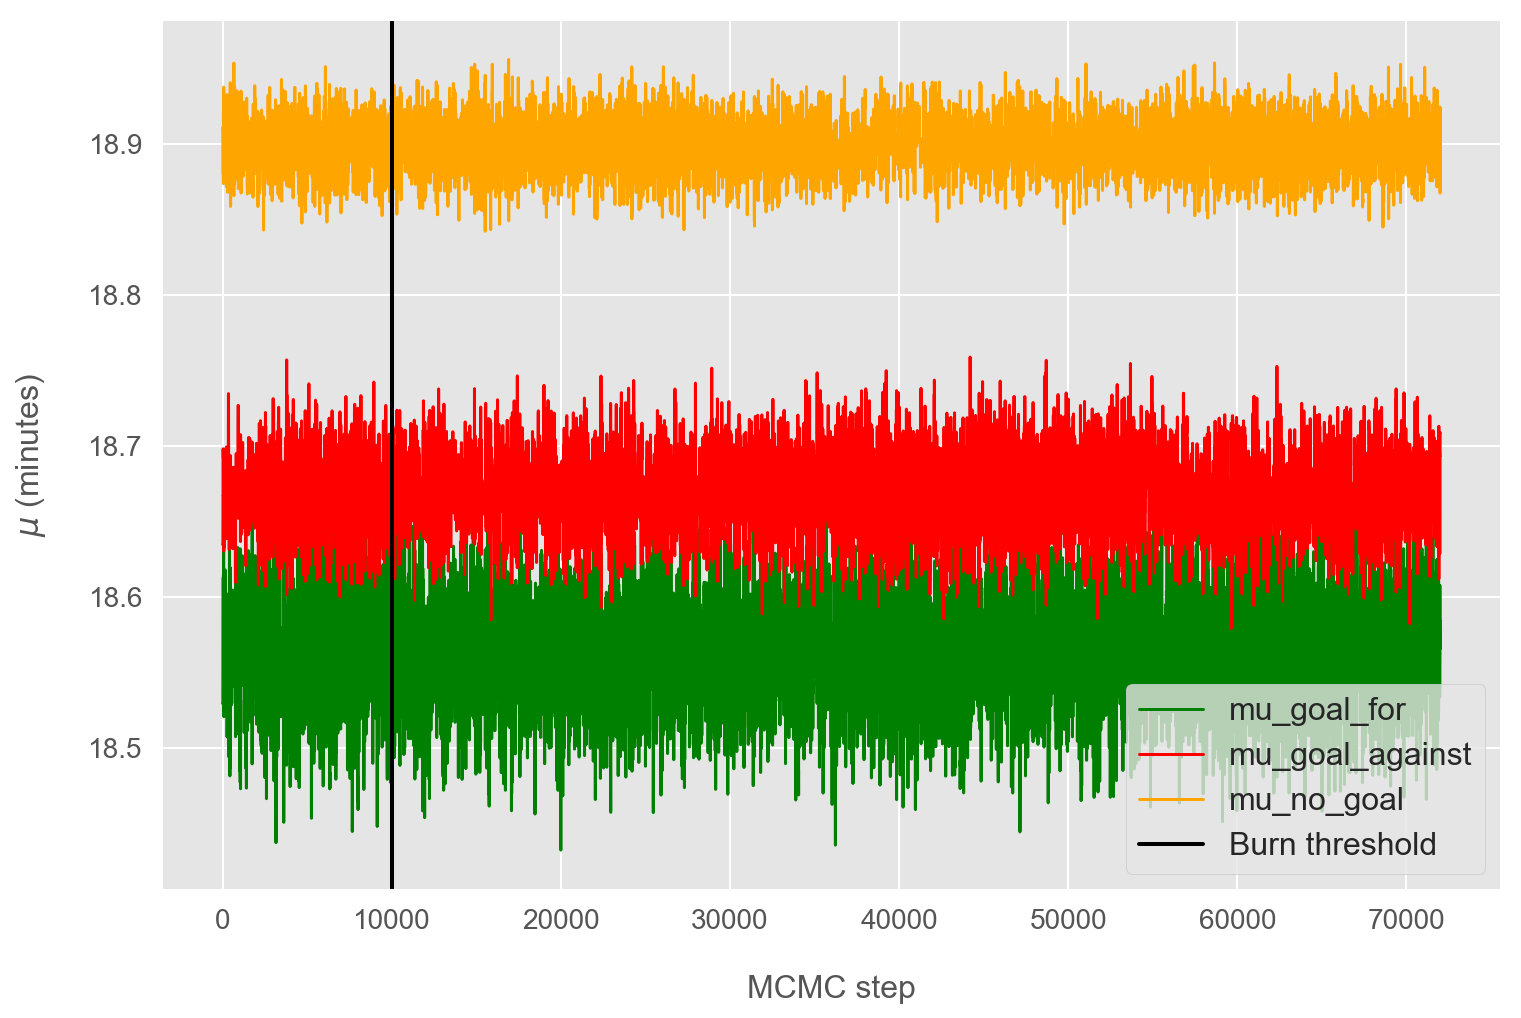

In [312]:
plt.plot(trace['mu_goal_for']/60, label='mu_goal_for', color='green')
plt.plot(trace['mu_goal_against']/60, label='mu_goal_against', color='red')
plt.plot(trace['mu_no_goal']/60, label='mu_no_goal', color='orange')
plt.ylabel('$\mu$ (minutes)')
plt.xlabel('MCMC step')

plt.axvline(N_burn, color='black', lw=2, label='Burn threshold')

plt.legend()

savefig(plt, 'time_elapsed_mu_steps')

plt.show()

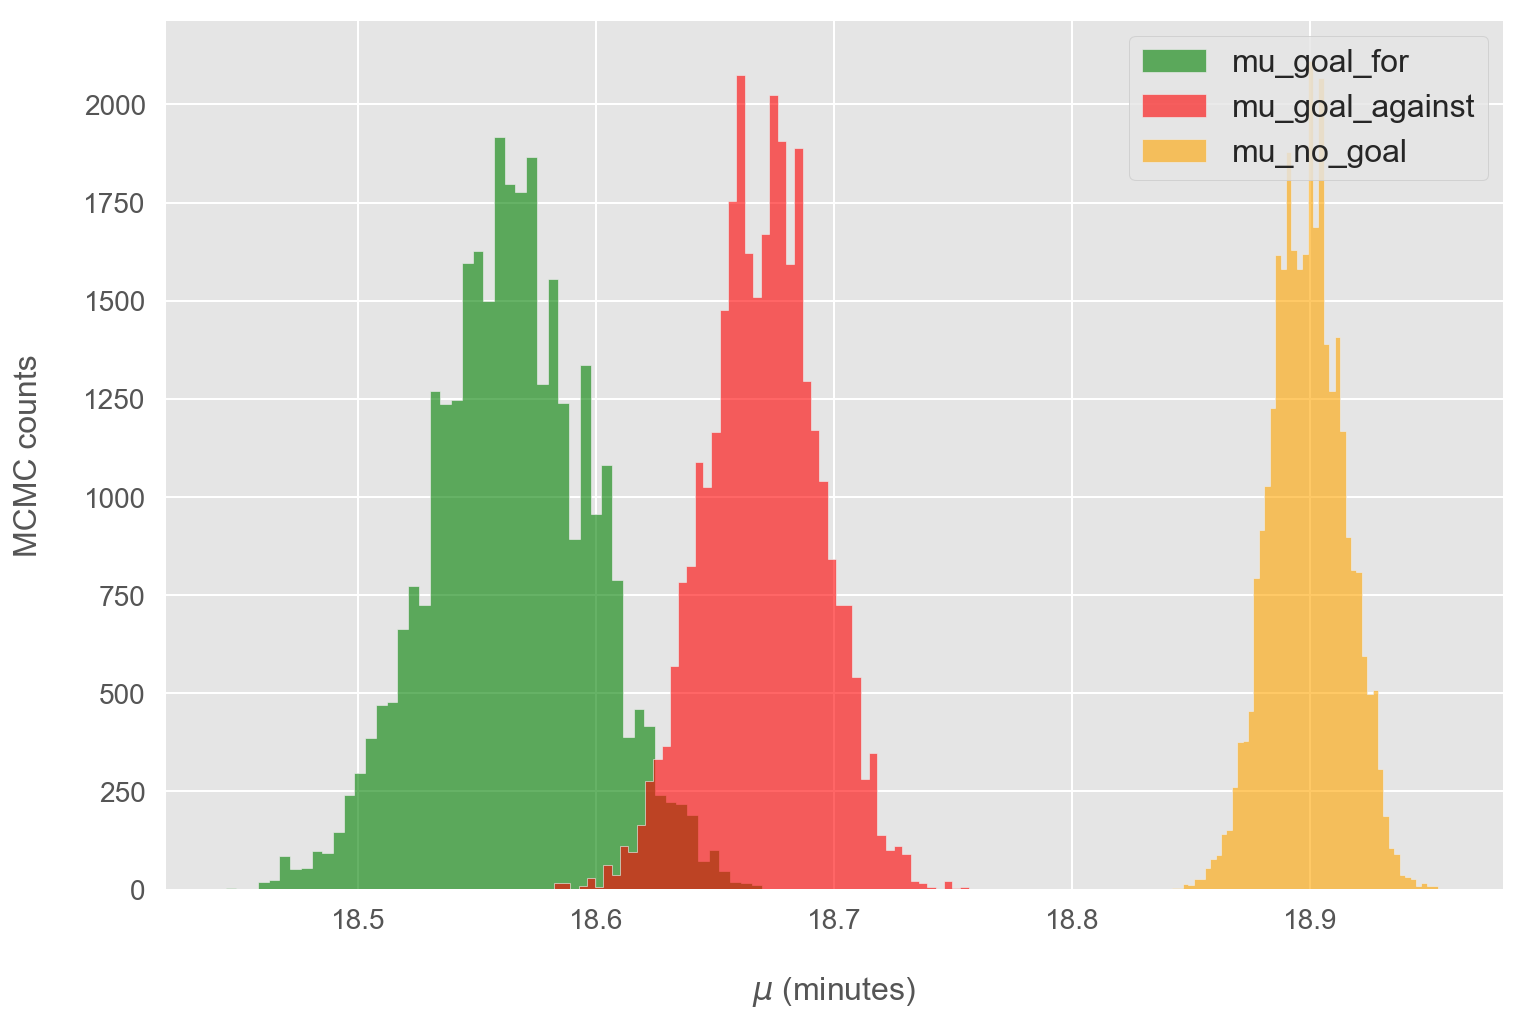

In [313]:
ALPHA = 0.6

plt.hist(burned_trace['mu_goal_for']/60, bins=50,
         color='green', label='mu_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_goal_against']/60, bins=50,
         color='red', label='mu_goal_against',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_no_goal']/60, bins=50,
         color='orange', label='mu_no_goal',
         histtype='stepfilled', alpha=ALPHA)

plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (minutes)')
plt.legend()

savefig(plt, 'time_elapsed_mu_samples')
plt.show()

Now I need to normalize these. Let's confirm equal sample numbers

In [314]:
(burned_trace['mu_goal_for'].shape,
burned_trace['mu_goal_against'].shape,
burned_trace['mu_no_goal'].shape)

((32000,), (32000,), (32000,))

In [315]:
len(burned_trace) * 4

32000

Nice! Same number of samlpes. Weird that it's 4x my burned trace amount - probably due to 4 cores

Let's define the average shape parameter $\mu$ and then solve for the normalizing fractions.

In [316]:
mu_mcmc = [
    burned_trace['mu_goal_for'].mean(),
    burned_trace['mu_goal_against'].mean(),
    burned_trace['mu_no_goal'].mean(),
]

print(f'MCMC values for mu: {mu_mcmc}')

MCMC values for mu: [1113.8610176719865, 1120.1978248818098, 1133.9227602973795]


In [317]:
mcmc_normalizing_factors = np.array([
    training_samples[0].shape[0],
     training_samples[1].shape[0],
     training_samples[2].shape[0]
])
mcmc_normalizing_factors = mcmc_normalizing_factors / mcmc_normalizing_factors.sum()

print(f'MCMC normalizing factors =\n{mcmc_normalizing_factors}')

MCMC normalizing factors =
[0.1268201  0.26021606 0.61296383]


In [318]:
from scipy.stats import poisson
p = poisson.pmf

x = np.arange(15*60, 20*60, 1)
y_goal_for = p(x, mu_mcmc[0]) * mcmc_normalizing_factors[0]
y_goal_against = p(x, mu_mcmc[1]) * mcmc_normalizing_factors[1]
y_no_goal = p(x, mu_mcmc[2]) * mcmc_normalizing_factors[2]

cutoff_renormed_factor = 2 - (y_goal_for.sum() + y_goal_against.sum() + y_no_goal.sum())
model_normalizing_factors = mcmc_normalizing_factors * cutoff_renormed_factor

print(f'Poisson normalizing factors =\n{model_normalizing_factors}')

Poisson normalizing factors =
[0.12928604 0.2652758  0.62488252]


Those ^ are the normalizing class probabilties

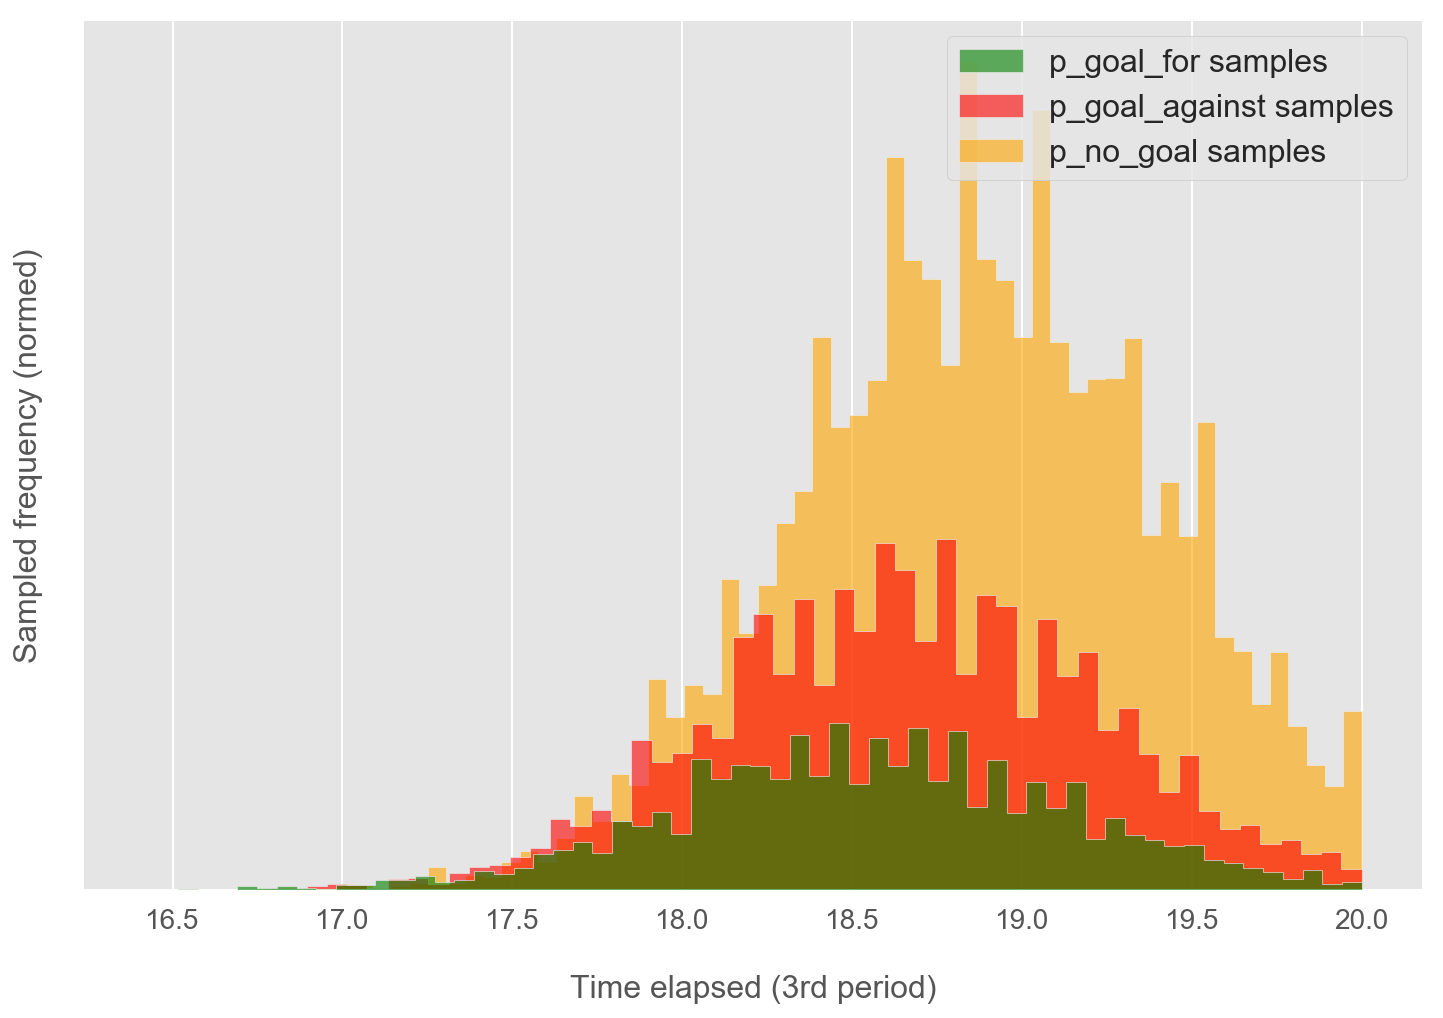

In [319]:
ALPHA = 0.6
LW = 3
BINS = 60

# plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
#          color='green', label=r'$P(\rm{goal\;for}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

# plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
#          color='red', label=r'$P(\rm{goal\;against}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

''' Plot the MCMC samples '''

plt.hist(np.random.choice(
            burned_trace['p_goal_for'] / 60,
            size=int(burned_trace['p_goal_for'].shape[0] * mcmc_normalizing_factors[0])
         ),
         bins=BINS, color='green', label='p_goal_for samples',
#          density='normed',
         histtype='stepfilled', alpha=ALPHA, zorder=3)

plt.hist(np.random.choice(
            burned_trace['p_goal_against'] / 60,
            size=int(burned_trace['p_goal_against'].shape[0] * mcmc_normalizing_factors[1])
         ),
         bins=BINS,
         color='red', label='p_goal_against samples',
#          density='normed',
         histtype='stepfilled', alpha=ALPHA, zorder=2)

plt.hist(np.random.choice(
            burned_trace['p_no_goal'] / 60,
            size=int(burned_trace['p_no_goal'].shape[0] * mcmc_normalizing_factors[2])
         ),
         bins=BINS,
         color='orange', label='p_no_goal samples',
#          density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.ylabel('Sampled frequency (normed)')
plt.yticks([])
plt.xlabel('Time elapsed (3rd period)')
plt.legend();

savefig(plt, 'time_elapsed_normed_poisson_mcmc_samples')

plt.show()

Re-normalize for cutoff Poisson distributions

In [321]:
y_goal_for.sum() + y_goal_against.sum() + y_no_goal.sum()

-2.835436989984692

In [325]:
import inspect
print(inspect.getsource(poisson_posterior))

def poisson_posterior(burned_trace) -> Tuple[np.ndarray]:
    p = poisson.pmf
    x = np.arange(15*60, 20*60, 1)

    mu_goal_for = burned_trace['mu_goal_for'].mean()
    mu_goal_against = burned_trace['mu_goal_against'].mean()
    mu_no_goal = burned_trace['mu_no_goal'].mean()

    y_goal_for = p(x, mu_goal_for)
    y_goal_against = p(x, mu_goal_against)
    y_no_goal = p(x, mu_no_goal)
    
    # Convert into minutes
    x = x / 60

    return x, y_goal_for, y_goal_against, y_no_goal



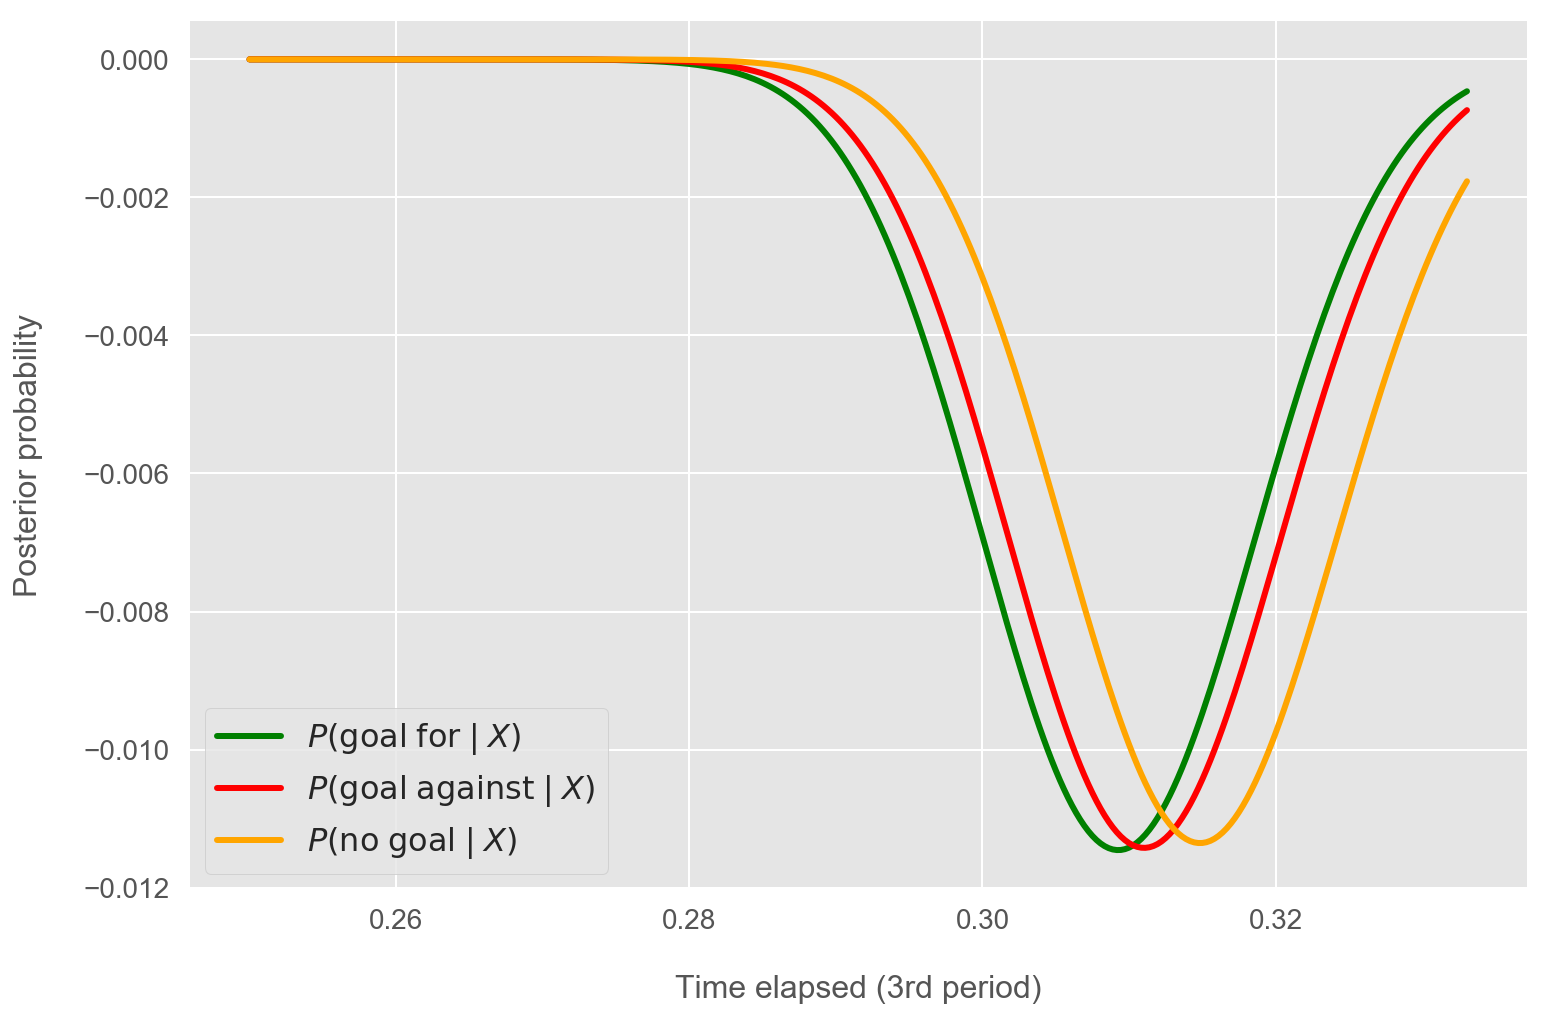

In [326]:
from scipy.stats import poisson
ALPHA = 0.6
LW = 3 

''' Plot the poisson distributions '''
x, y_goal_for, y_goal_against, y_no_goal = poisson_posterior(burned_trace)

# p = poisson.pmf
# x = np.arange(16*60, 20*60, 1)
# mu_goal_for = burned_trace['mu_goal_for'].mean()
# mu_goal_against = burned_trace['mu_goal_against'].mean()
# mu_no_goal = burned_trace['mu_no_goal'].mean()
# y_goal_for = p(x, mu_goal_for) * normed_factors[0]
# y_goal_against = p(x, mu_goal_against) * normed_factors[1]
# y_no_goal = p(x, mu_no_goal) * normed_factors[2]

cutoff_renormed_factor = 2 - (y_goal_for.sum() + y_goal_against.sum() + y_no_goal.sum())
y_goal_for = y_goal_for * cutoff_renormed_factor
y_goal_against = y_goal_against * cutoff_renormed_factor
y_no_goal = y_no_goal * cutoff_renormed_factor

# Convert into minutes and rescale to fit chart
x = x / 60
# scale_frac = 0.7
# y_goal_for = y_goal_for / y_goal_for.max() * normed_factors[0]
# y_goal_against = y_goal_against / y_goal_against.max() * normed_factors[1]
# y_no_goal = y_no_goal / y_no_goal.max() * normed_factors[2]

plt.plot(x, y_goal_for, label=r'$P(\mathrm{goal\;for}\;|\;X)$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\mathrm{goal\;against}\;|\;X)$', color='red', lw=LW)
plt.plot(x, y_no_goal, label=r'$P(\mathrm{no\;goal}\;|\;X)$', color='orange', lw=LW)

plt.ylabel('Posterior probability')
# plt.yticks([])
plt.xlabel('Time elapsed (3rd period)')
plt.legend()

savefig(plt, 'time_elapsed_normed_poisson')

plt.show()

In [277]:
y_goal_for.sum() + y_goal_against.sum() + y_no_goal.sum()

0.9996219061224255

In [278]:
def convert_to_time_remaining(x):
    _x = 20 - x
    t = datetime.timedelta(seconds=_x*60)
    return str(t)

convert_to_time_remaining(x[np.argmax(y_goal_for)])

'0:01:27'

In [279]:
print('Time of max posterior probability =\n'
      f'{x[np.argmax(y_goal_for)], x[np.argmax(y_goal_against)], x[np.argmax(y_no_goal)]}')

print()

t_remaining = [convert_to_time_remaining(x[np.argmax(y_goal_for)]),
              convert_to_time_remaining(x[np.argmax(y_goal_against)]),
              convert_to_time_remaining(x[np.argmax(y_no_goal)])]

print(f'Time of max posterior probability =\n{t_remaining}')

Time of max posterior probability =
(18.55, 18.666666666666668, 18.883333333333333)

Time of max posterior probability =
['0:01:27', '0:01:20', '0:01:07']


Great, now we have properly normalized probabilties.

Notes:
 - From normalizing factors, we can see ~12% chance of scoring when pulling the goalie on average.
 - Probability of scoring peaks at 18.55 mins (1:27 remaining), with other probabilties following close after (01:20 for goal against and 01:07 for no goals)
 
From now on we'll work from the distributions as our source of truth. These are hard coded below to help with reproducibility.

In [280]:
model_normlizing_factors = [
    0.1292882,
    0.26528024,
    0.62489297,
]

mu_mcmc = [
    1113.8279468130681,
    1120.1830172722719,
    1133.9420018554083
]

Calculating the CDF will allow us to make some interesting observations on the results.

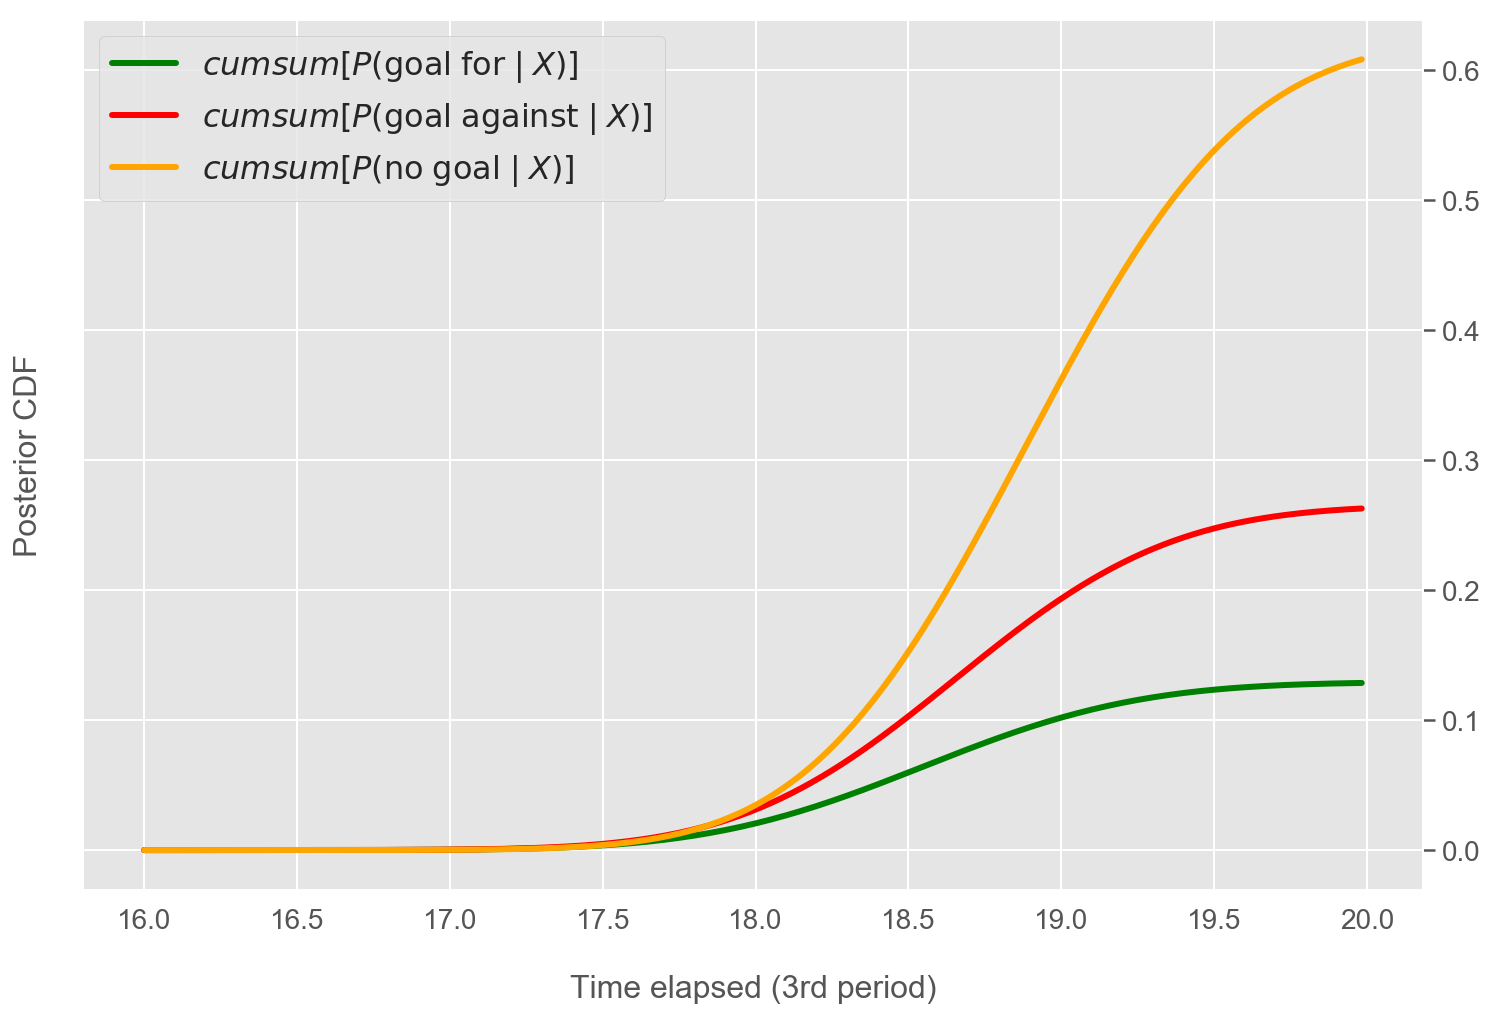

In [288]:
plt.plot(x, np.cumsum(y_goal_for), label=r'$cumsum [ P(\mathrm{goal\;for}\;|\;X) ]$', color='green', lw=LW)
plt.plot(x, np.cumsum(y_goal_against), label=r'$cumsum [ P(\mathrm{goal\;against}\;|\;X) ]$', color='red', lw=LW)
plt.plot(x, np.cumsum(y_no_goal), label=r'$cumsum [ P(\mathrm{no\;goal}\;|\;X) ]$', color='orange', lw=LW)

plt.ylabel('Posterior CDF')
# plt.yticks([])
plt.xlabel('Time elapsed (3rd period)')
plt.legend()

ax = plt.gca()
ax.yaxis.tick_right()

savefig(plt, 'time_elapsed_poisson_cdf')

plt.show()

The end of game values have been normalized sum up to one, but this ratio changes over time. We can visualize this with the risk-reward ratio.

Let's look at the chance of scoring a goal, compared to either outcome. We want to maximze this.

### Rough work

#### Data loading

In [6]:
def load_training_samples(
    df,
    cols,
    masks=[],
    dtype='timedelta64[s]'
) -> np.ndarray:
    '''
    Return buckets of training data.
    '''
    if not masks:
        masks = [None] * len(cols)
    out = []
    for col, m in zip(cols, masks):
        if m is None:
            d = df[col].dropna().astype(dtype).values
        else:
            d = df[col][m].dropna().astype(dtype).values
        out.append(d)
        print(f'Loaded {len(d)} samples for col {col}')

    out = np.array(out)
    print(f'Training data shape = {out.shape}')
    return out

Let's start by modeling the 5 on 6 goal times in 3rd period, where time is a continuous (or rather, discretized by second) and measured in minutes.

In [7]:
features = ['goal_for_time', 'goal_against_time']
training_samples = load_training_samples(df, features)

Loaded 270 samples for col goal_for_time
Loaded 554 samples for col goal_against_time
Training data shape = (2,)


In [8]:
training_samples[0].shape

(270,)

In [9]:
training_samples[0][:10]

array([1180., 1124., 1157., 1168., 1118., 1183., 1130., 1116., 1172.,
       1181.])

To get the proper probabilities, we should weight the 

#### Modeling

In [48]:
# with pm.Model() as model:
#     prior_goal_for = pm.Uniform('prior_goal_for', 15, 20)
#     prior_goal_against = pm.Uniform('prior_goal_against', 15, 20)
#     obs_goal_for = pm.Gamma('obs_goal_for', observed=training_samples[0])

# need to set up priors for all the parameters of the gamma!...
# THINK ABOUT IT

In [60]:
from scipy.stats import poisson

In [61]:
poisson?

```
pmf(k, mu, loc=0)   
    Probability mass function.
```

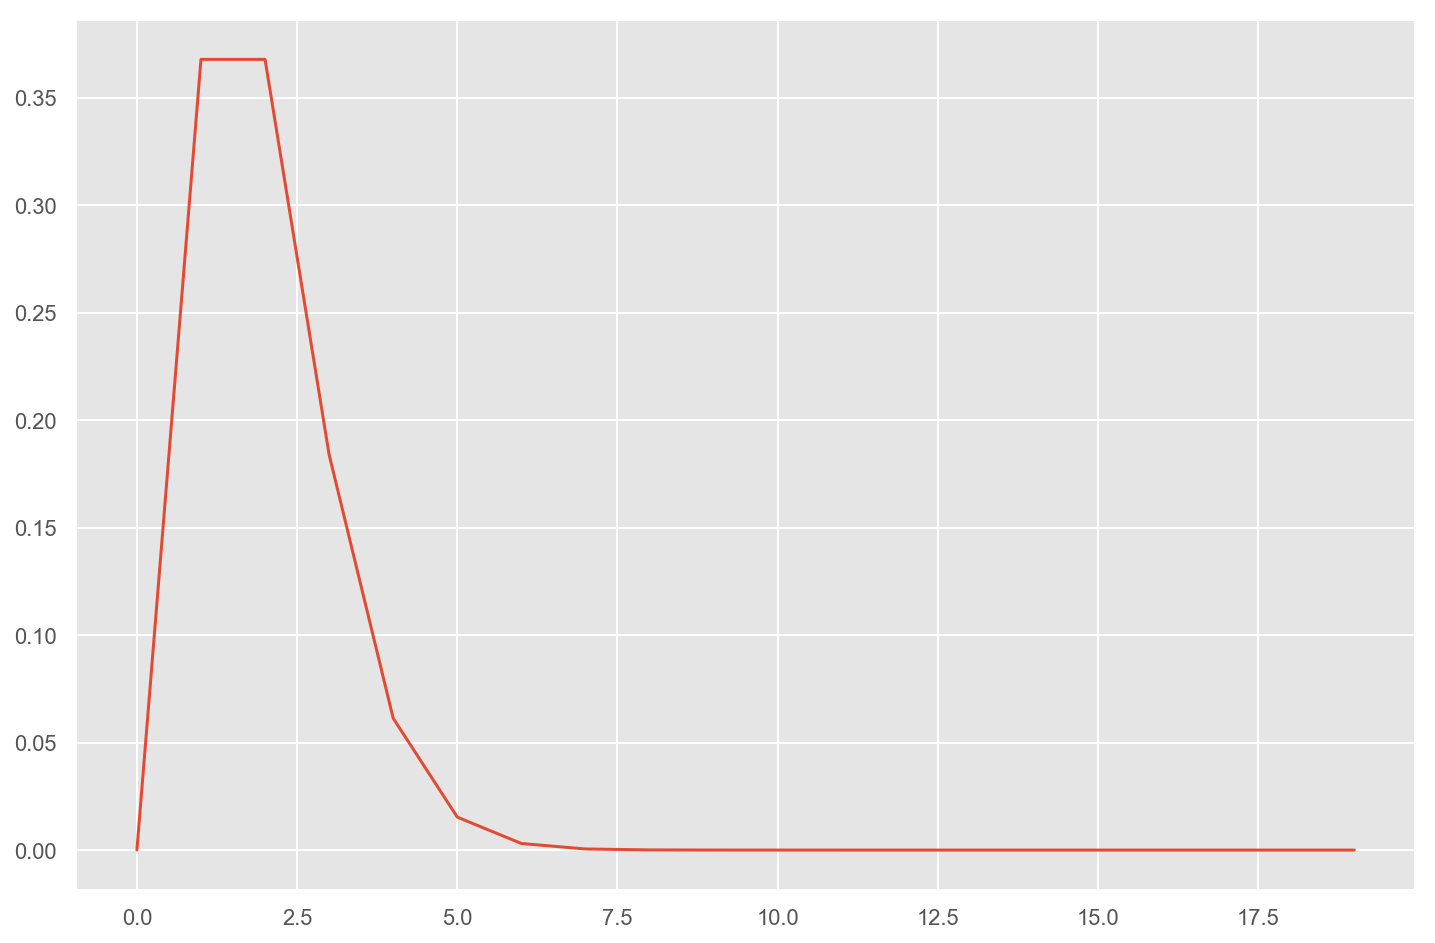

In [63]:
x = np.arange(0, 20, 1)
y = [poisson.pmf(_x, 1, 1)
     for _x in x]
plt.plot(x, y)

In [49]:
def bayes_model(training_samples):
    
    with pm.Model() as model:

        # Priors for the mu parameter of the poisson distribution
        # Note that mu = mean(Poisson)
        mu_goal_for = pm.Uniform('mu_goal_for', 15*60, 20*60)
        mu_goal_against = pm.Uniform('mu_goal_against', 15*60, 20*60)

        # Observations
        obs_goal_for = pm.Poisson('obs_goal_for', mu_goal_for, observed=training_samples[0])
        obs_goal_against = pm.Poisson('obs_goal_against', mu_goal_against, observed=training_samples[1])
        
        # Priors for the goal probabilities
        p_goal_for = pm.Poisson('p_goal_for', mu_goal_for)
        p_goal_against = pm.Poisson('p_goal_against', mu_goal_against)

        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

# N = 10
# test_training_samples = np.array([training_samples[0][:N],
#                                   training_samples[1][:N]])
# model, trace, burned_trace = bayes_model(test_training_samples)
# model

In [50]:
model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_goal_against]
>Metropolis: [p_goal_for]
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:19<00:00, 3839.72draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [51]:
N_burn = 10000
burned_trace = trace[N_burn:]

In [52]:
pm.plots.traceplot?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1ebe9e48>,
      dtype=object)

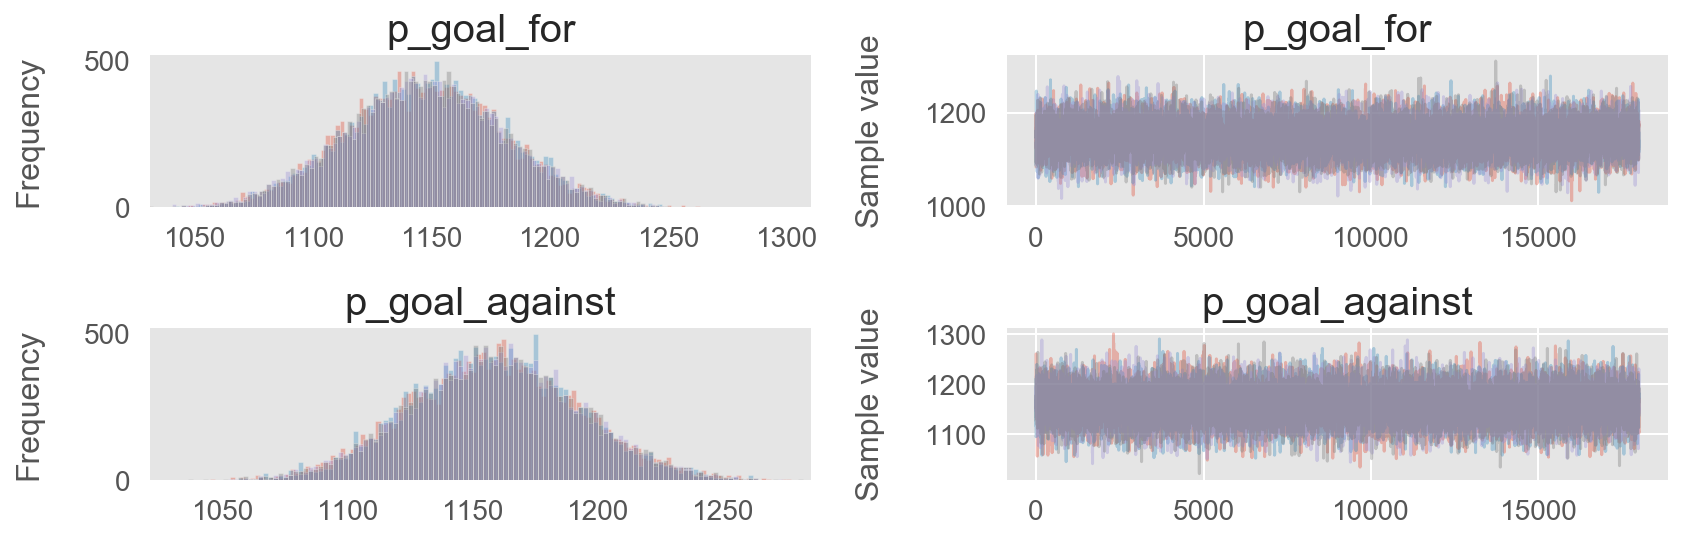

In [53]:
pm.plots.traceplot(trace=trace, varnames=['p_goal_for', 'p_goal_against'])

What do red and blue represent? 

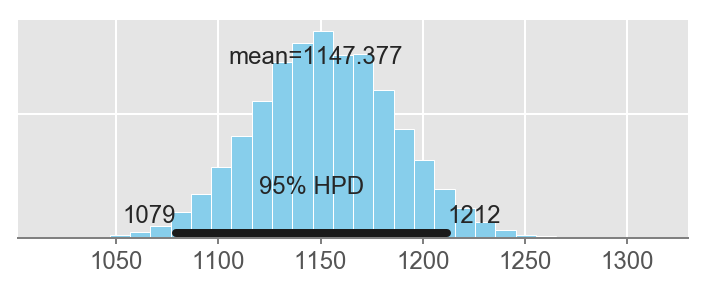

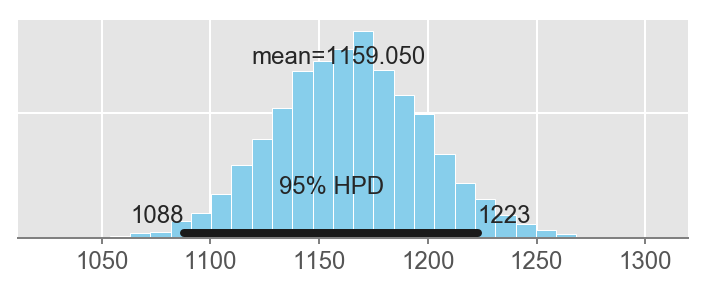

In [60]:
pm.plots.plot_posterior(trace=trace['p_goal_for'])
pm.plots.plot_posterior(trace=trace['p_goal_against'])

The HDR is really interesting! For the above case (normally distributed data), the HDR is pretty much equivalent to the SD based confience interval. However it generalizes to more complicated distributions 

https://stats.stackexchange.com/questions/148439/what-is-a-highest-density-region-hdr
e.g. 

![](https://i.stack.imgur.com/Dy89t.png)

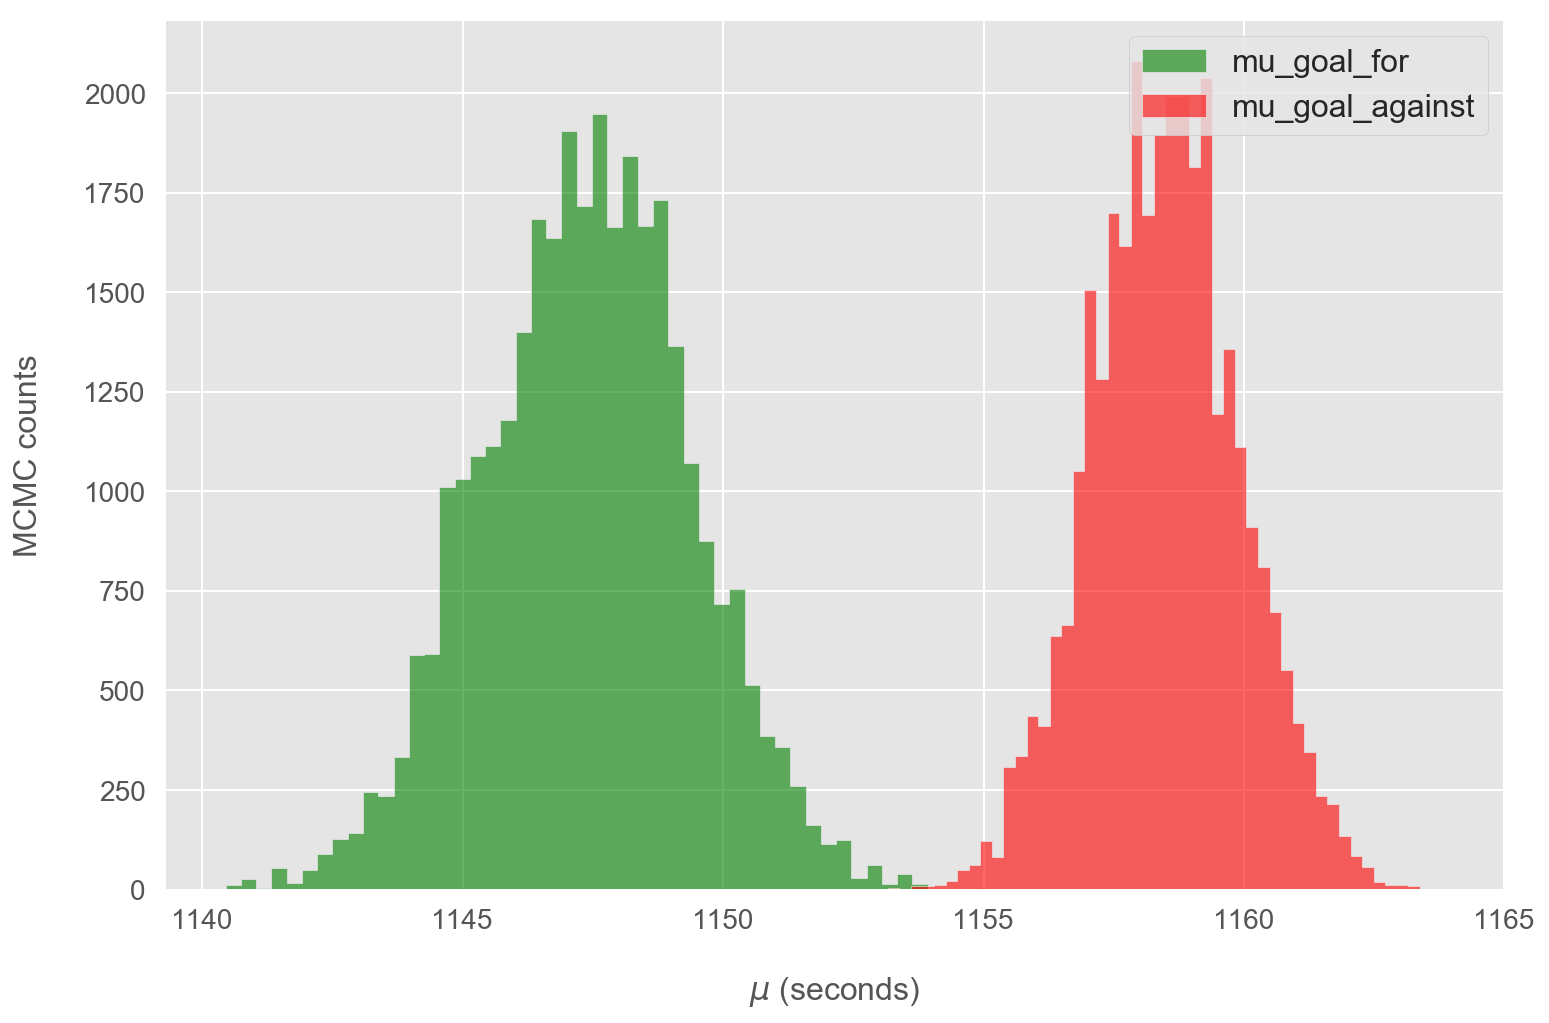

In [62]:
ALPHA = 0.6

plt.hist(burned_trace['mu_goal_for'], bins=50,
         color='green', label='mu_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_goal_against'], bins=50,
         color='red', label='mu_goal_against',
         histtype='stepfilled', alpha=ALPHA)
plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (seconds)')
plt.legend();

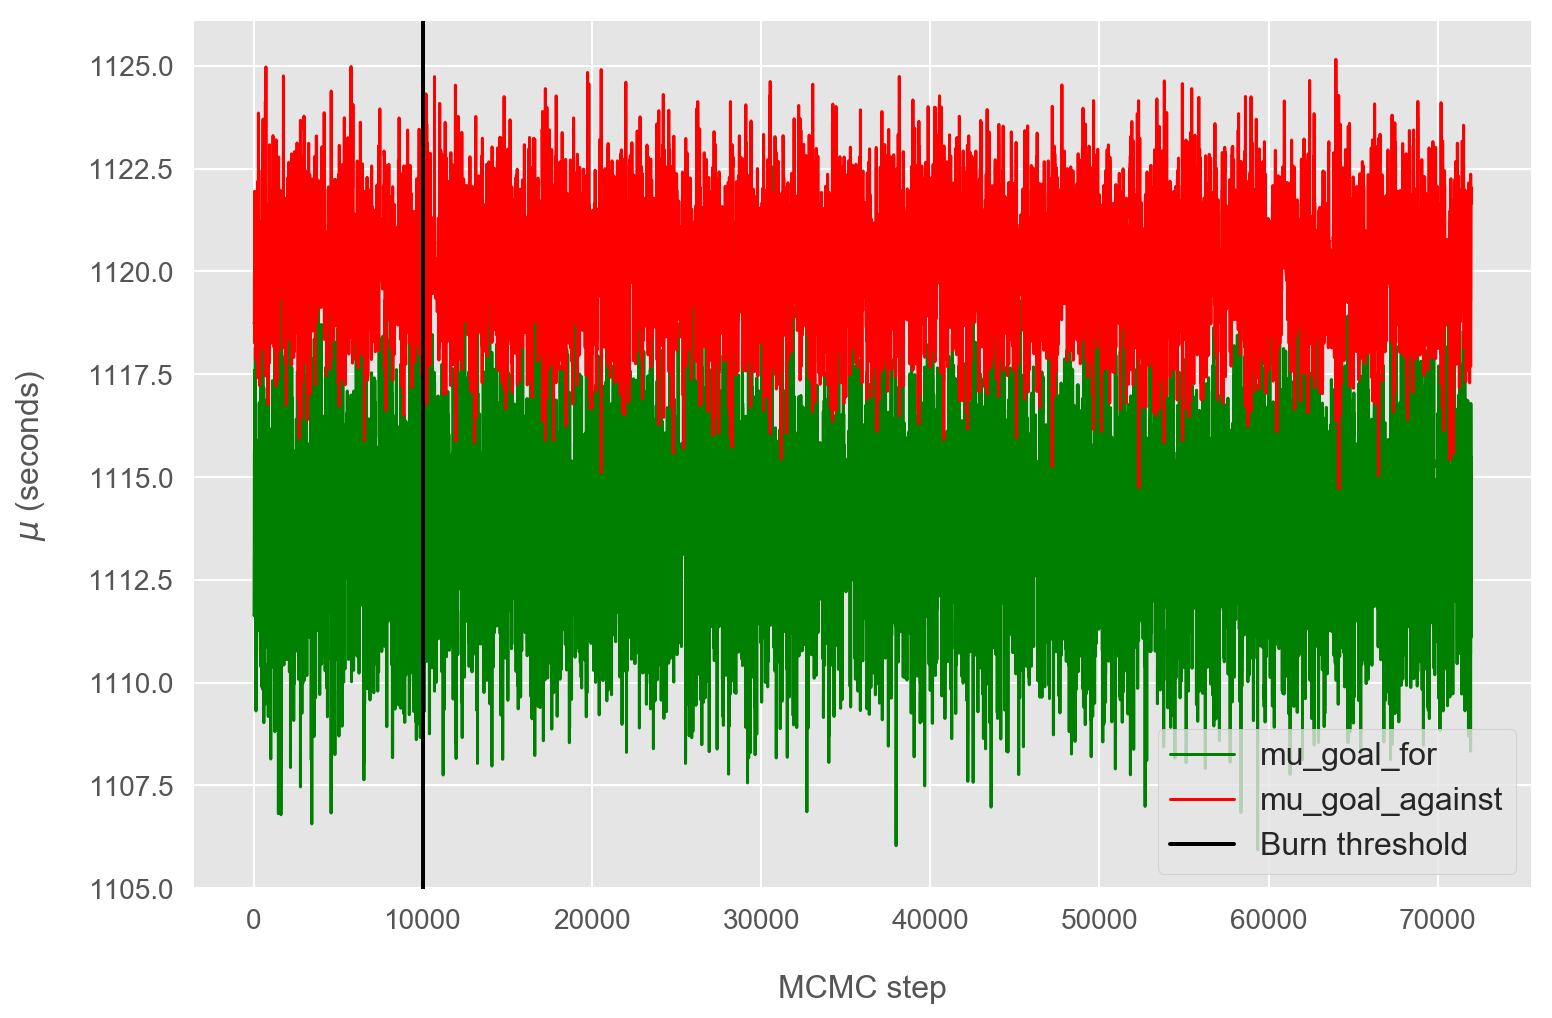

In [88]:
plt.plot(trace['mu_goal_for'], label='mu_goal_for', color='green')
plt.plot(trace['mu_goal_against'], label='mu_goal_against', color='red')
plt.ylabel('$\mu$ (seconds)')
plt.xlabel('MCMC step')

plt.axvline(N_burn, color='black', lw=2, label='Burn threshold')

plt.legend();

Include both those plots in blog ^

In [64]:
from scipy.special import factorial
poisson = lambda mu, k: mu**k * np.exp(-mu) / factorial(k)
poisson(0.5, np.array([1, 4, 5, 2]))

array([3.03265330e-01, 1.57950693e-03, 1.57950693e-04, 7.58163325e-02])

In [65]:
from scipy.stats import poisson

In [66]:
poisson.pmf?

In [67]:
poisson.pmf(3, 1)

0.06131324019524039

In [68]:
poisson.pmf(np.array([1, 4, 3]), 1)

array([0.36787944, 0.01532831, 0.06131324])

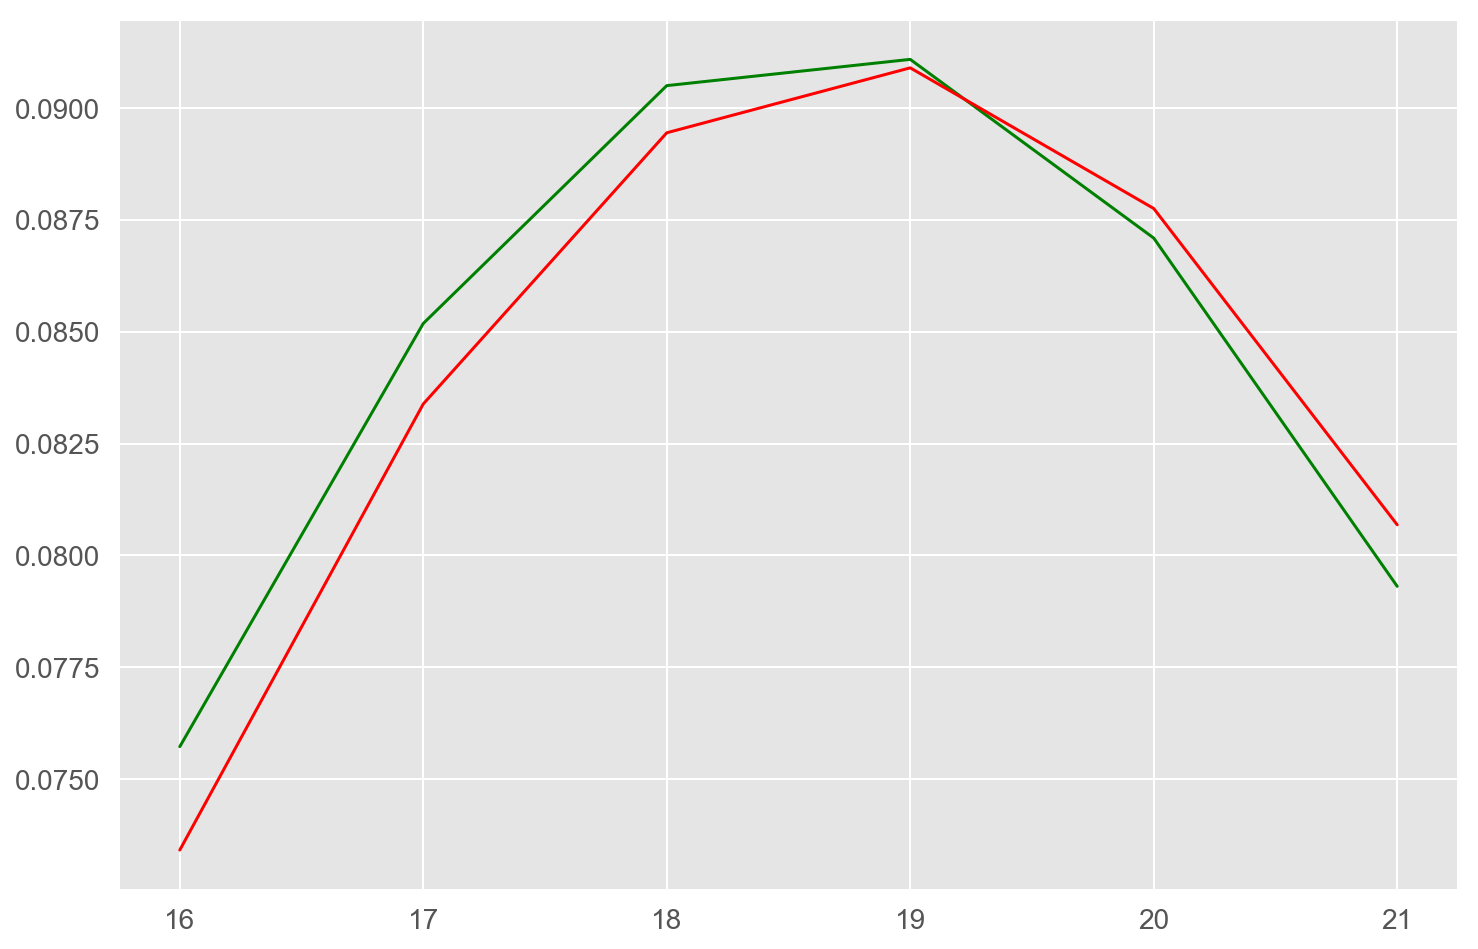

In [69]:
p = poisson.pmf
# poisson = lambda k, mu: mu**k * np.exp(-mu) / factorial(k)

x = np.arange(16, 22, 1)

mu_goal_for = burned_trace['mu_goal_for'].mean() / 60
y_goal_for = p(x, mu_goal_for)

mu_goal_against = burned_trace['mu_goal_against'].mean() / 60
y_goal_against = p(x, mu_goal_against)

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{avg})$', color='green')
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{avg})$', color='red')

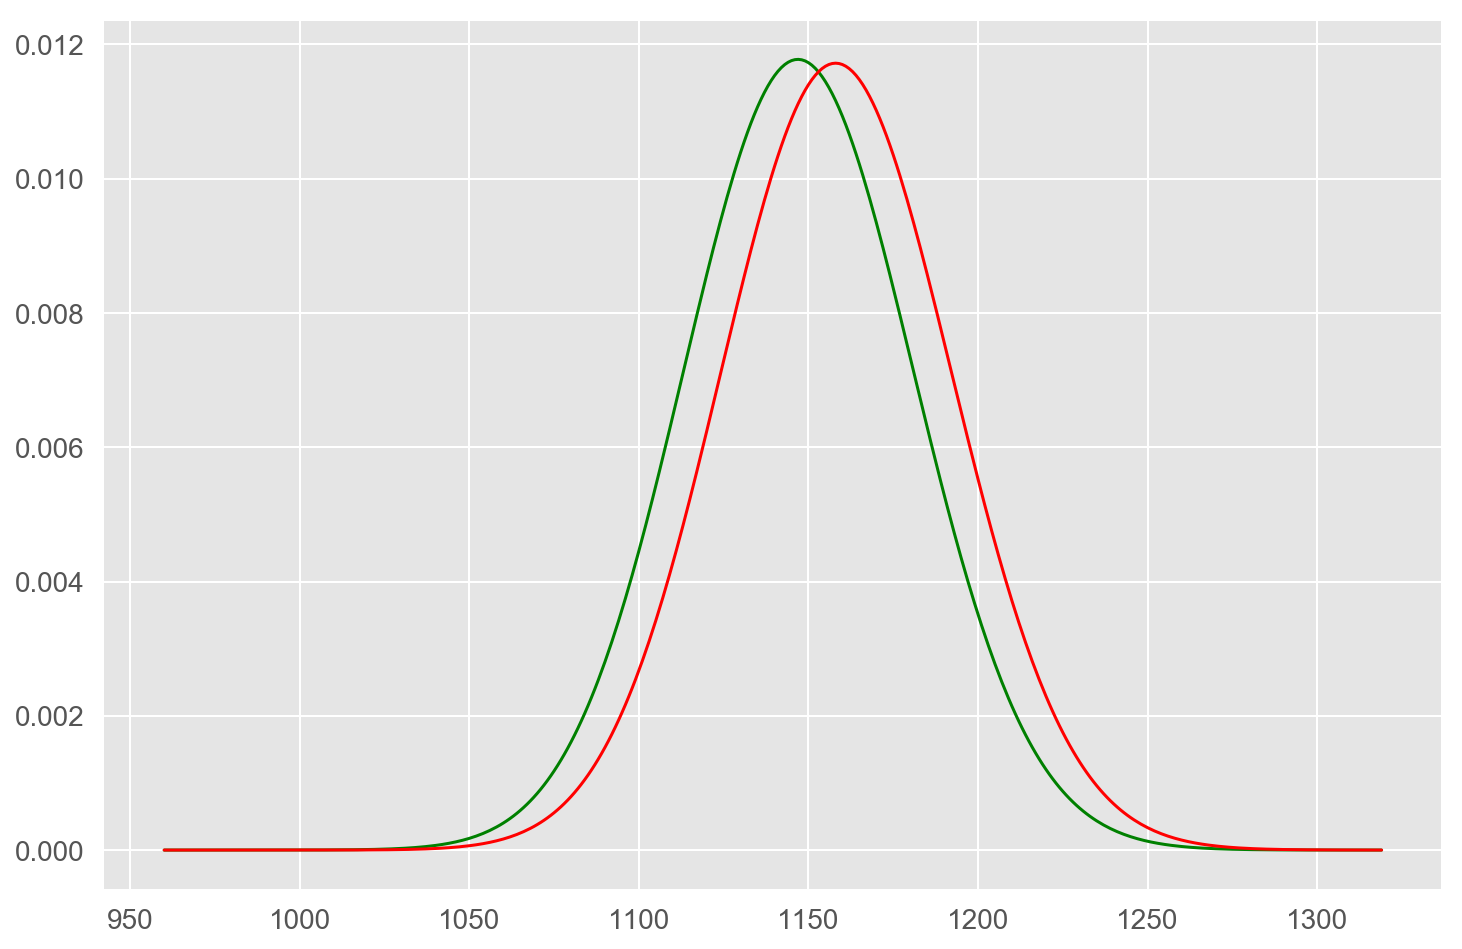

In [70]:
p = poisson.pmf
# poisson = lambda k, mu: mu**k * np.exp(-mu) / factorial(k)

x = np.arange(16*60, 22*60, 1)

mu_goal_for = burned_trace['mu_goal_for'].mean()
y_goal_for = p(x, mu_goal_for)

mu_goal_against = burned_trace['mu_goal_against'].mean()
y_goal_against = p(x, mu_goal_against)

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{avg})$', color='green')
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{avg})$', color='red')

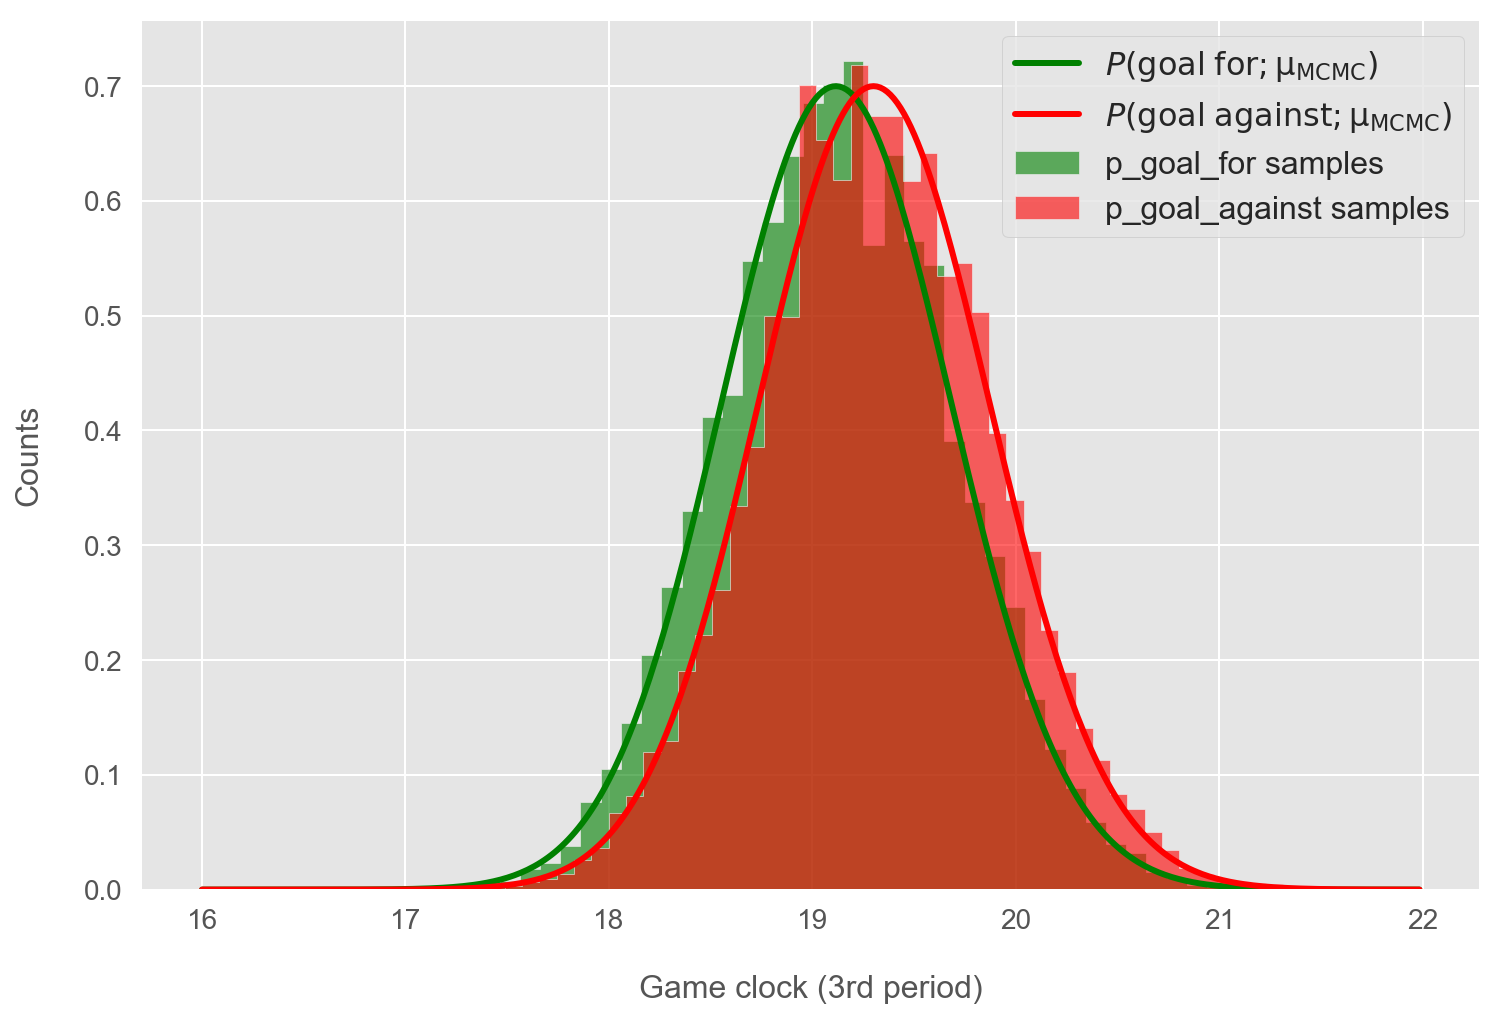

In [72]:
ALPHA = 0.6
LW = 3

# plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
#          color='green', label=r'$P(\rm{goal\;for}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

# plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
#          color='red', label=r'$P(\rm{goal\;against}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

''' Plot the MCMC samples '''

plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
         color='green', label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
         color='red', label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

''' Plot the poisson distributions '''

p = poisson.pmf
x = np.arange(16*60, 22*60, 1)
mu_goal_for = burned_trace['mu_goal_for'].mean()
mu_goal_against = burned_trace['mu_goal_against'].mean()
y_goal_for = p(x, mu_goal_for)
y_goal_against = p(x, mu_goal_against)

# Convert into minutes and rescale to fit chart
x = x / 60
scale_frac = 0.7
y_goal_for = y_goal_for / y_goal_for.max() * scale_frac
y_goal_against = y_goal_against / y_goal_against.max() * scale_frac

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{MCMC})$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{MCMC})$', color='red', lw=LW)

plt.ylabel('Counts')
# plt.yticks([])
plt.xlabel('Game clock (3rd period)')
plt.legend();

(Do not include this plot ^ in blog, but re-use source code)

In reality, the probability of an empty net goal should be zero after 20 minutes (since the period is over). We would also need to normalize the probabilities such that   

$
\sum_t \big{[} P(\mathrm{goal\;for}; \mu, t) + P(\mathrm{goal\;against}; \mu, t) + P(\mathrm{game\;end}) \big{]} = 1
$

Since this was just a toy model to get us warmed up with `pymc`, let's just leave this and move on to a more interesting problem.

---

#### Re-loead better training samples

I wonder if we can answer the question: **what are the odds of scoring a goal based on when the goalie is pulled?**

It's probably best to decide that based on the "time since goalie pull" metric and the time remaining in the game. For the chart above, the goal for probability is clearly shifted to the left - however this does not mean that pulling a goalie at the 19 minute mark will have lower odds of a good outcome than pulling at the 18 minute mark. This chart is just a litlihood of scoring given the goalie pull times.

What we should do is label the goalie pull times with the eventual outcome, then model that.

In [73]:
df.columns

Index(['season', 'game_number', 'team_name', 'date', 'pull_period',
       'pull_time', 'goal_for_time', 'goal_against_time', 'goal_for_timedelta',
       'goal_against_timedelta', 'game_end_timedelta'],
      dtype='object')

In [84]:
# Load time of pull for eventual outcomes:
feature_names = ['goal_for', 'goal_against']

# Logic for loading the data
features = ['pull_time', 'pull_time']
masks = [~(df.goal_for_time.isnull()), ~(df.goal_against_time.isnull())]
training_samples = load_training_samples(df, features, masks)

Loaded 270 samples for col pull_time
Loaded 554 samples for col pull_time
Training data shape = (2,)


In [115]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Model() as model:

        # Priors for the mu parameter of the poisson distribution
        # Note that mu = mean(Poisson)
        mu_goal_for = pm.Uniform('mu_goal_for', 15*60, 20*60)
        mu_goal_against = pm.Uniform('mu_goal_against', 15*60, 20*60)

        # Observations
        obs_goal_for = pm.Poisson('obs_goal_for', mu_goal_for, observed=training_samples[0])
        obs_goal_against = pm.Poisson('obs_goal_against', mu_goal_against, observed=training_samples[1])
        
        # Priors for the goal probabilities
        p_goal_for = pm.Poisson('p_goal_for', mu_goal_for)
        p_goal_against = pm.Poisson('p_goal_against', mu_goal_against)

        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_goal_against]
>Metropolis: [p_goal_for]
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:19<00:00, 3735.10draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [116]:
N_burn = 10000
burned_trace = trace[N_burn:]

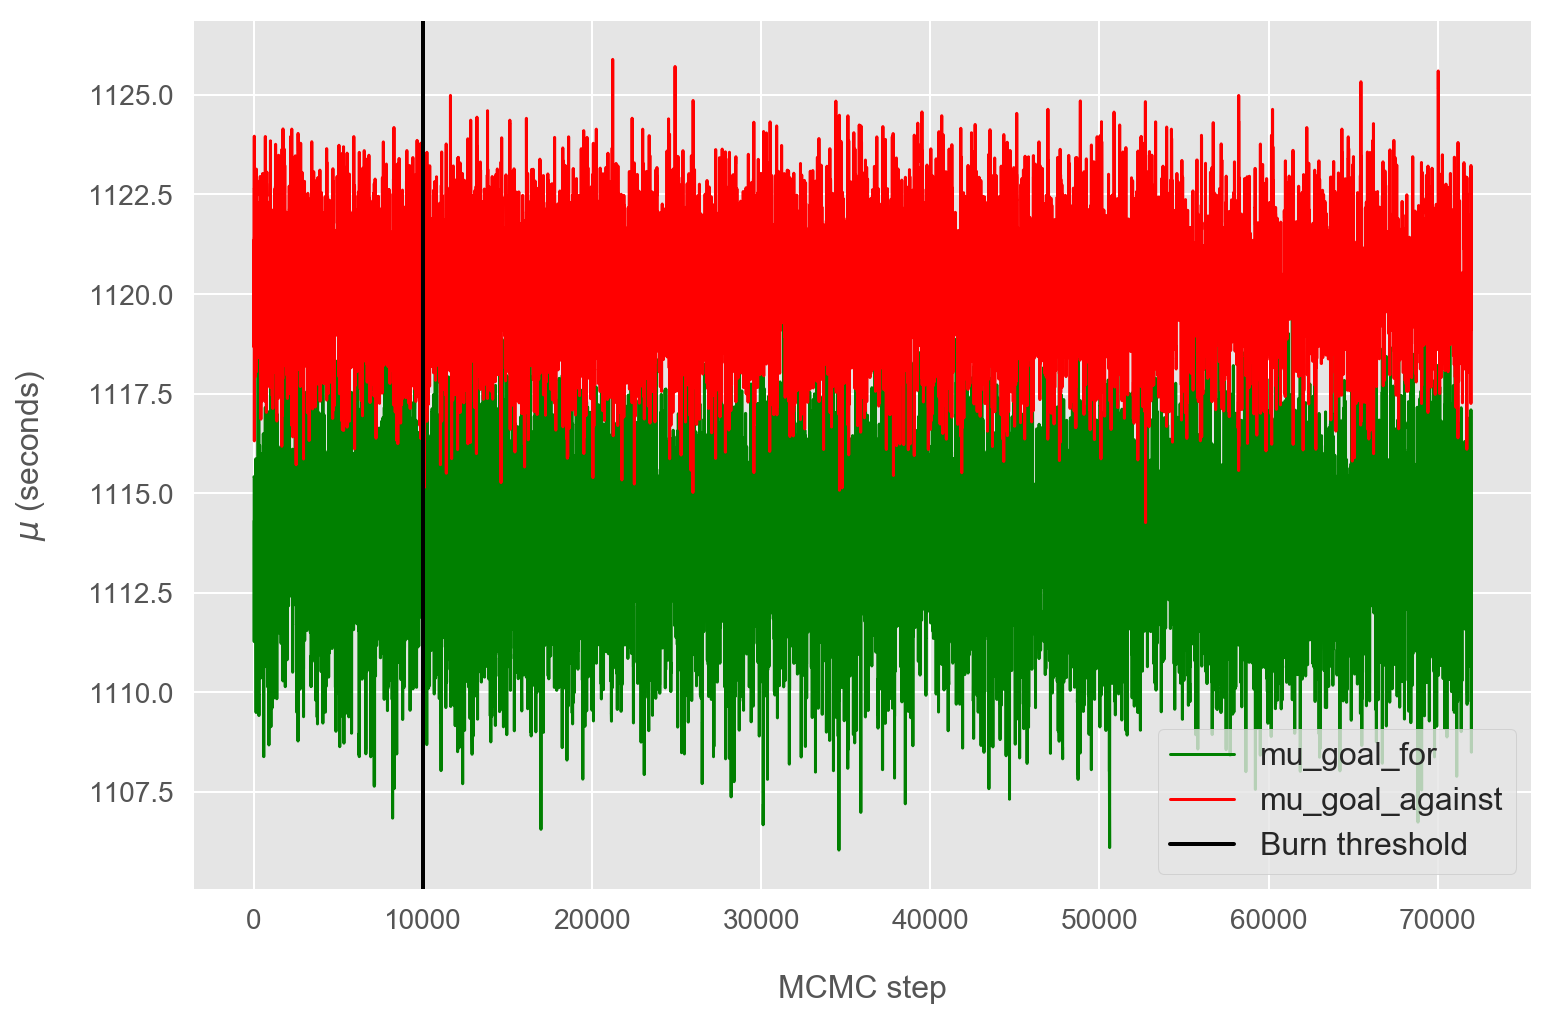

In [117]:
plt.plot(trace['mu_goal_for'], label='mu_goal_for', color='green')
plt.plot(trace['mu_goal_against'], label='mu_goal_against', color='red')
plt.ylabel('$\mu$ (seconds)')
plt.xlabel('MCMC step')

plt.axvline(N_burn, color='black', lw=2, label='Burn threshold')

plt.legend();

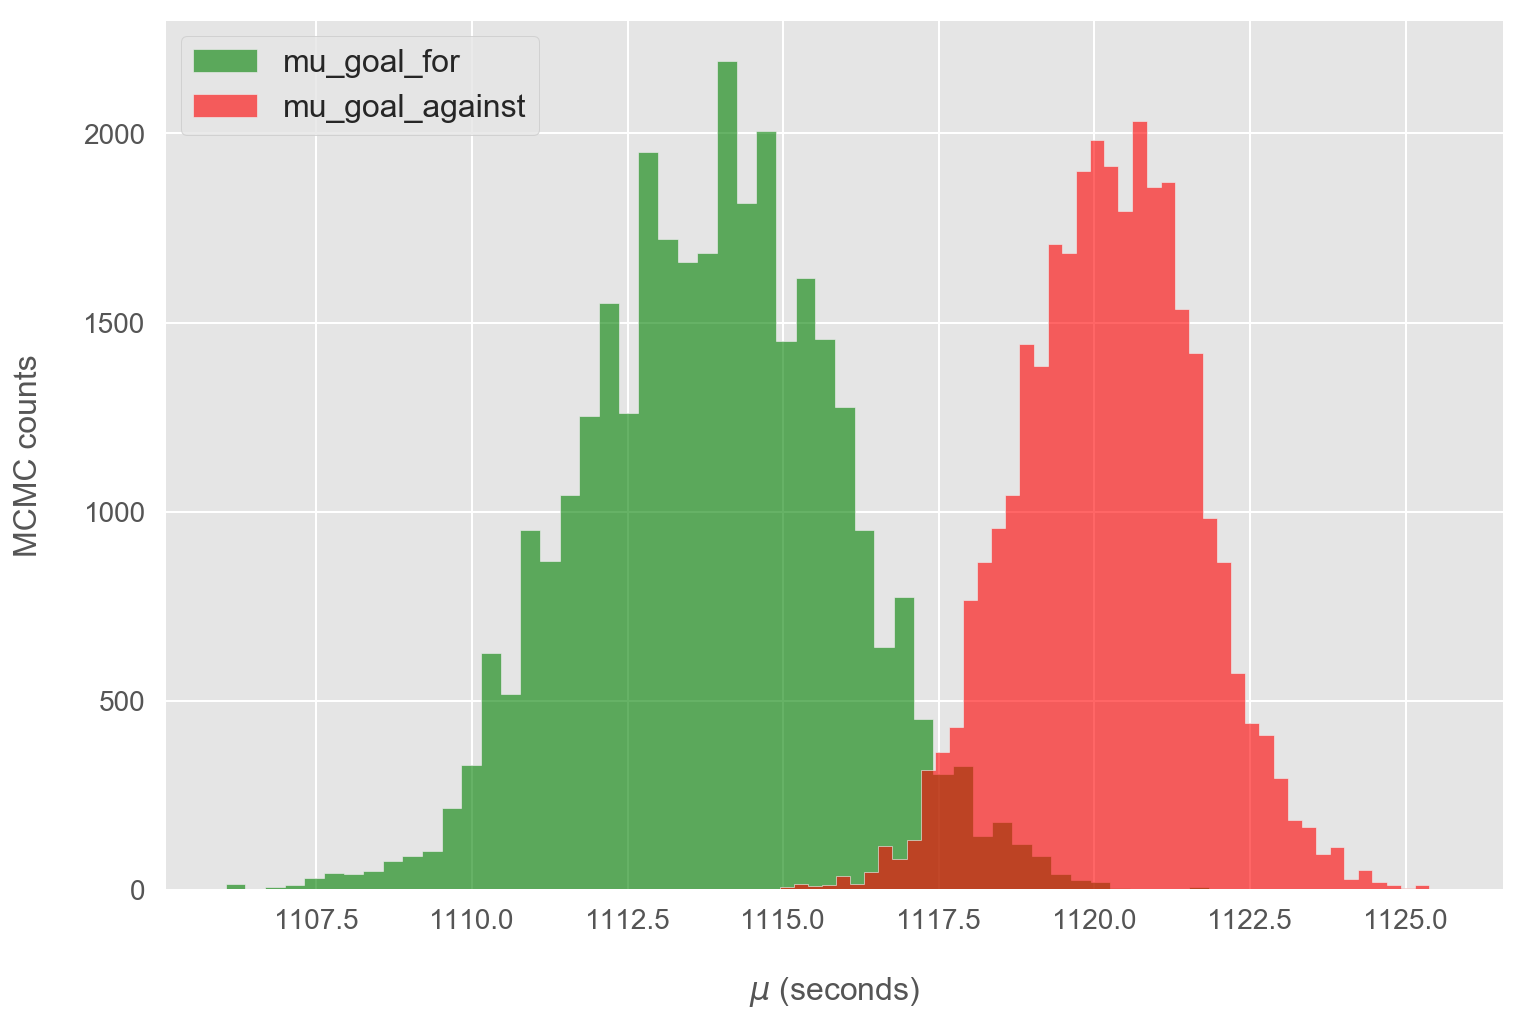

In [118]:
ALPHA = 0.6

plt.hist(burned_trace['mu_goal_for'], bins=50,
         color='green', label='mu_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_goal_against'], bins=50,
         color='red', label='mu_goal_against',
         histtype='stepfilled', alpha=ALPHA)
plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (seconds)')
plt.legend();

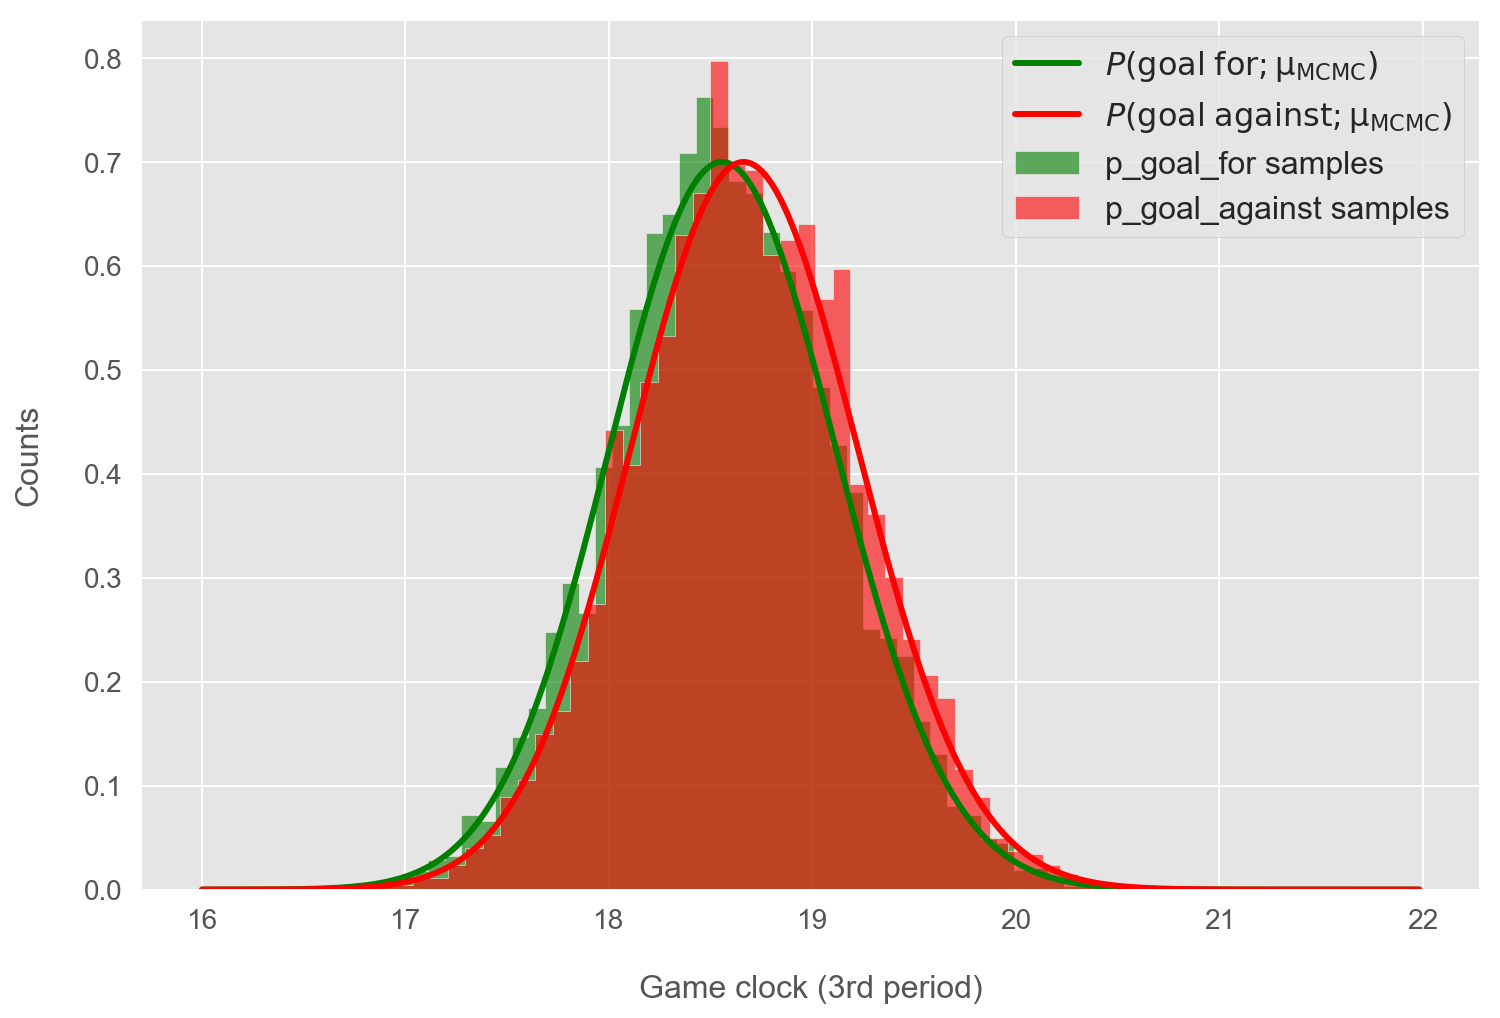

In [119]:
ALPHA = 0.6
LW = 3

# plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
#          color='green', label=r'$P(\rm{goal\;for}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

# plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
#          color='red', label=r'$P(\rm{goal\;against}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

''' Plot the MCMC samples '''

plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
         color='green', label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
         color='red', label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

''' Plot the poisson distributions '''

p = poisson.pmf
x = np.arange(16*60, 22*60, 1)
mu_goal_for = burned_trace['mu_goal_for'].mean()
mu_goal_against = burned_trace['mu_goal_against'].mean()
y_goal_for = p(x, mu_goal_for)
y_goal_against = p(x, mu_goal_against)

# Convert into minutes and rescale to fit chart
x = x / 60
scale_frac = 0.7
y_goal_for = y_goal_for / y_goal_for.max() * scale_frac
y_goal_against = y_goal_against / y_goal_against.max() * scale_frac

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{MCMC})$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{MCMC})$', color='red', lw=LW)

plt.ylabel('Counts')
# plt.yticks([])
plt.xlabel('Game clock (3rd period)')
plt.legend();

Let's test this with a uniform prior

In [102]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Model() as model:

        # Priors for the goal probabilties
        # Last 5 minutes of the game, in seconds
#         p_goal_for = pm.Uniform('p_goal_for', 15*60, 20*60)
#         p_goal_against = pm.Uniform('p_goal_against', 15*60, 20*60)

        # Priors for the mu parameter of the poisson distribution
        # Note that mu = mean(Poisson)
        mu_goal_for = pm.Uniform('mu_goal_for', 15*60, 20*60)
        mu_goal_against = pm.Uniform('mu_goal_against', 15*60, 20*60)
        
        # Observations
        obs_goal_for = pm.Poisson(
            'obs_goal_for',
            mu=mu_goal_for,
            observed=training_samples[0],
        )
        obs_goal_against = pm.Poisson(
            'obs_goal_against',
            mu=mu_goal_against,
            observed=training_samples[1],
        )
        
        p_goal_for = pm.Deterministic(
            'p_goal_for', pm.Poisson('posterior_for', mu_goal_for)
        )
        p_goal_against = pm.Deterministic(
            'p_goal_against', pm.Poisson('posterior_against', mu_goal_against)
        )

        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [posterior_against]
>Metropolis: [posterior_for]
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:21<00:00, 3425.21draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [103]:
N_burn = 10000
burned_trace = trace[N_burn:]


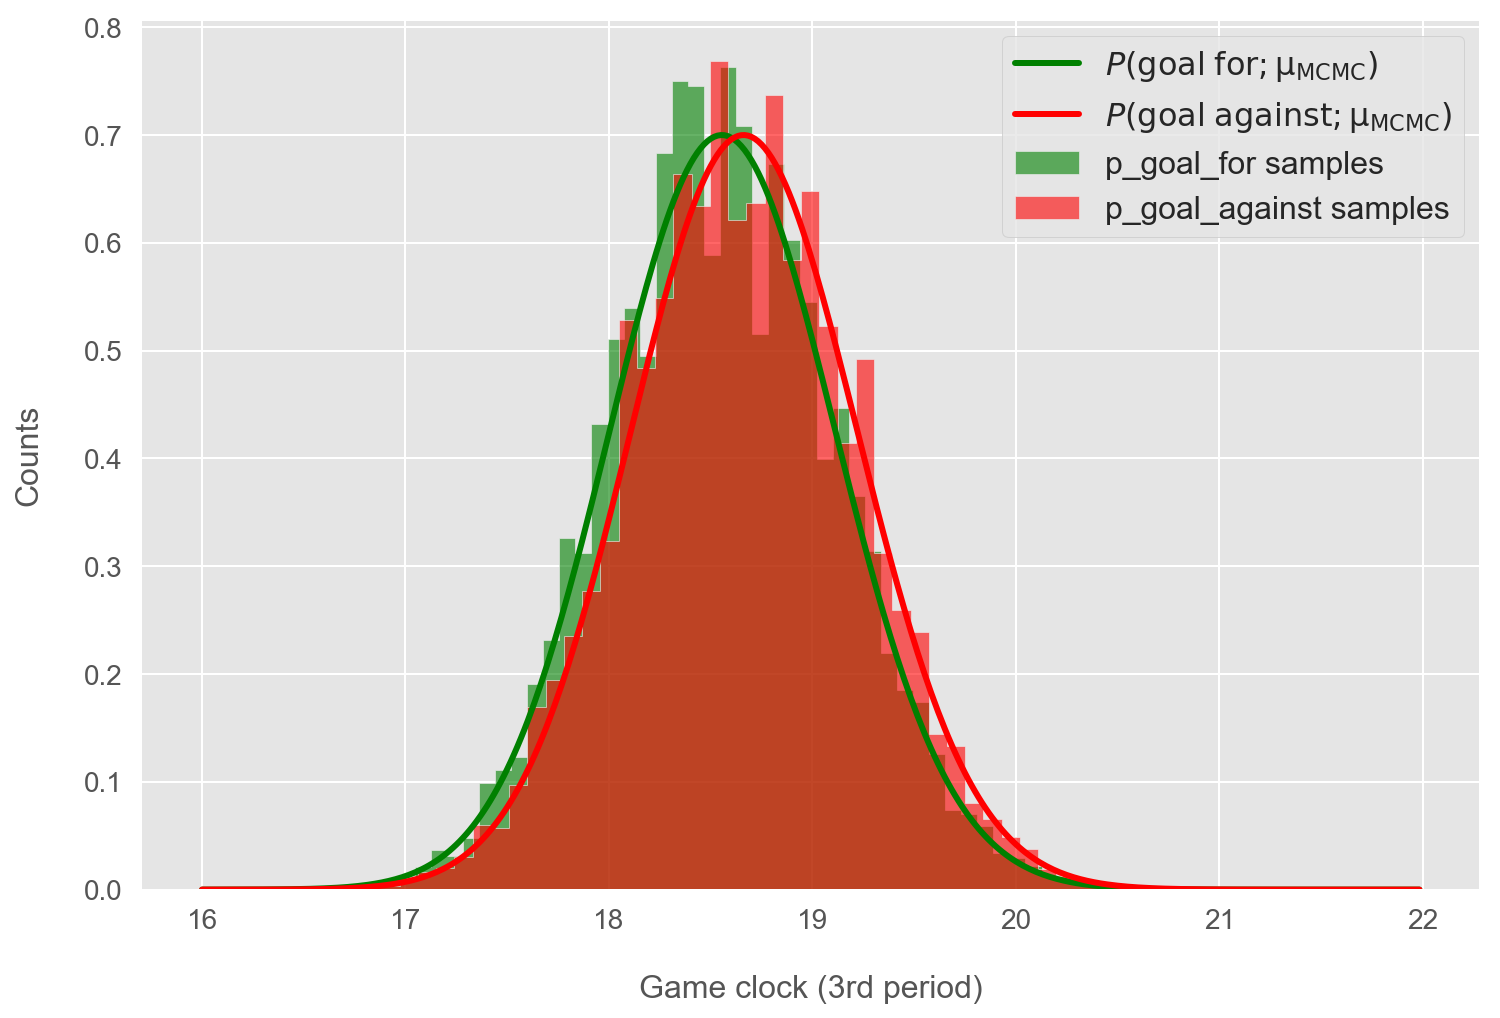

In [104]:
ALPHA = 0.6
LW = 3

# plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
#          color='green', label=r'$P(\rm{goal\;for}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

# plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
#          color='red', label=r'$P(\rm{goal\;against}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

''' Plot the MCMC samples '''

plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
         color='green', label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
         color='red', label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

''' Plot the poisson distributions '''

p = poisson.pmf
x = np.arange(16*60, 22*60, 1)
mu_goal_for = burned_trace['mu_goal_for'].mean()
mu_goal_against = burned_trace['mu_goal_against'].mean()
y_goal_for = p(x, mu_goal_for)
y_goal_against = p(x, mu_goal_against)

# Convert into minutes and rescale to fit chart
x = x / 60
scale_frac = 0.7
y_goal_for = y_goal_for / y_goal_for.max() * scale_frac
y_goal_against = y_goal_against / y_goal_against.max() * scale_frac

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{MCMC})$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{MCMC})$', color='red', lw=LW)

plt.ylabel('Counts')
# plt.yticks([])
plt.xlabel('Game clock (3rd period)')
plt.legend();
plt.show()

In [108]:
trace['mu_goal_for'].mean(), trace['mu_goal_against'].mean()

(1113.8427407009685, 1120.1907318776757)

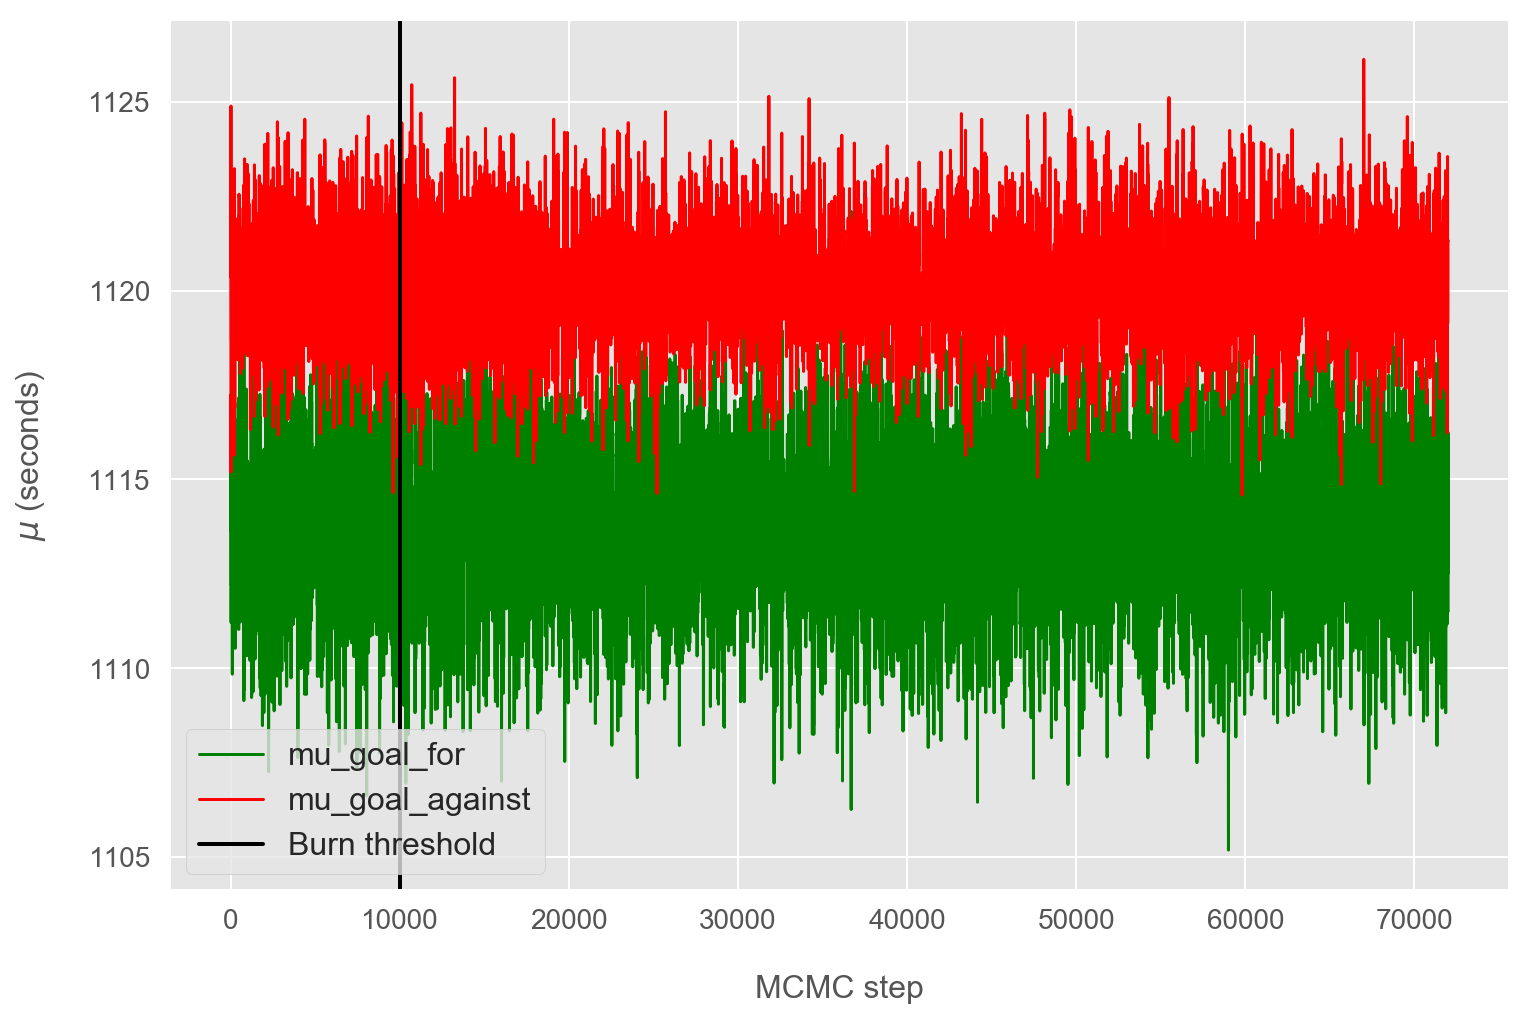

In [105]:
plt.plot(trace['mu_goal_for'], label='mu_goal_for', color='green')
plt.plot(trace['mu_goal_against'], label='mu_goal_against', color='red')
plt.ylabel('$\mu$ (seconds)')
plt.xlabel('MCMC step')

plt.axvline(N_burn, color='black', lw=2, label='Burn threshold')

plt.legend();

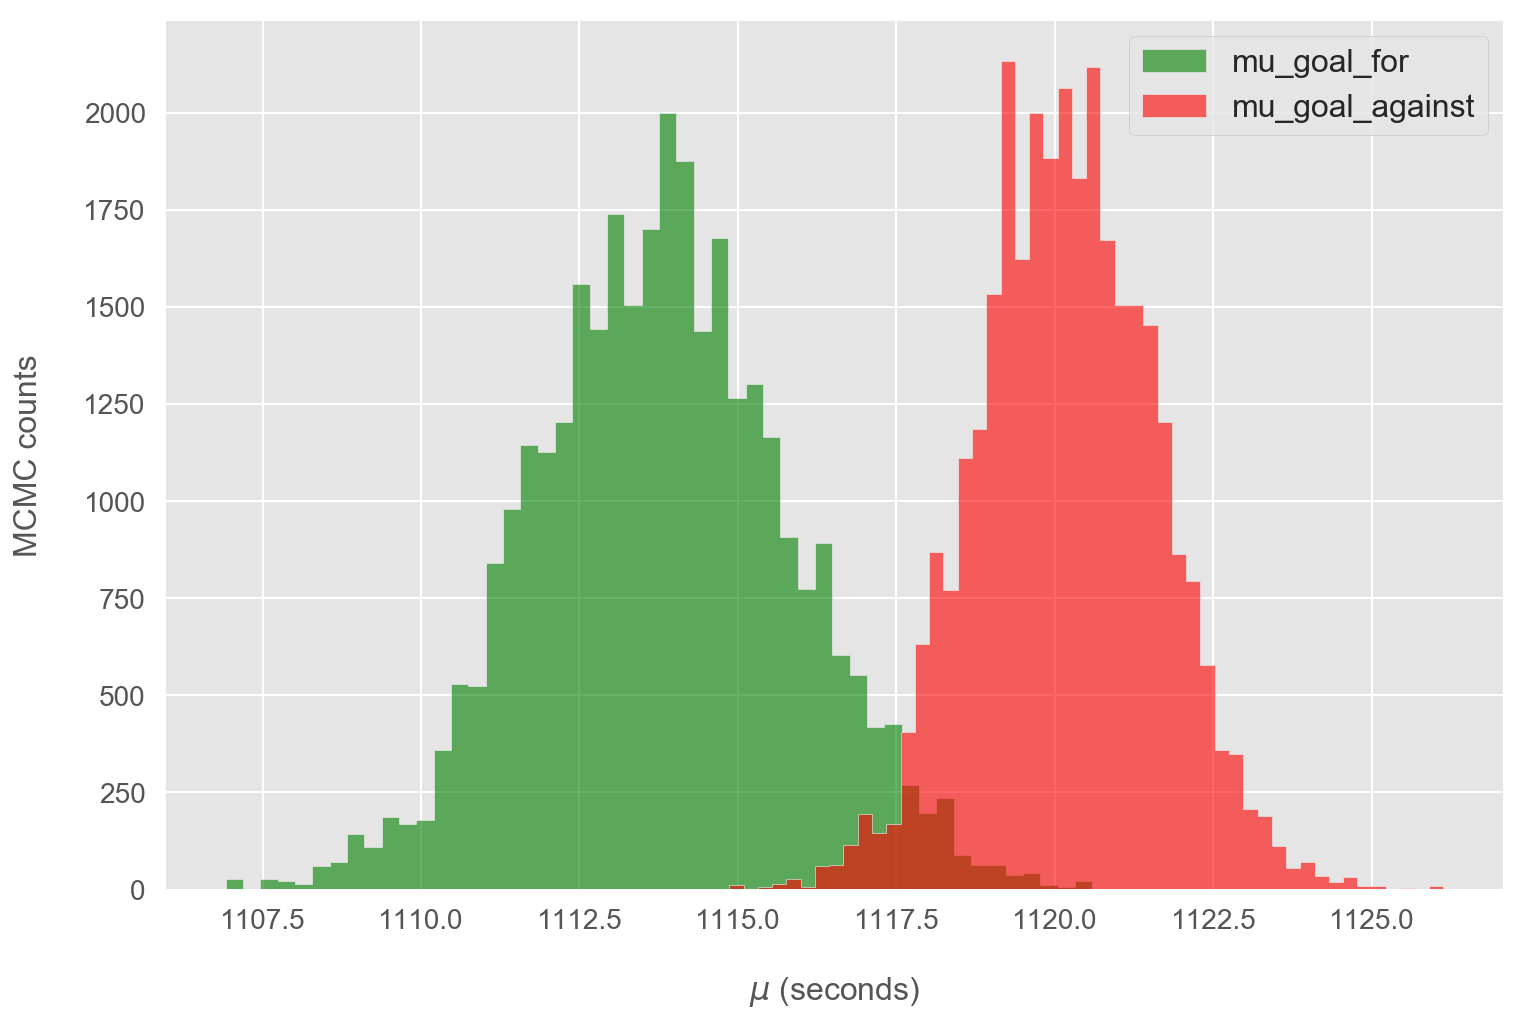

In [106]:
ALPHA = 0.6

plt.hist(burned_trace['mu_goal_for'], bins=50,
         color='green', label='mu_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_goal_against'], bins=50,
         color='red', label='mu_goal_against',
         histtype='stepfilled', alpha=ALPHA)
plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (seconds)')
plt.legend();

In [107]:
burned_trace.varnames

['mu_goal_for_interval__',
 'mu_goal_against_interval__',
 'posterior_for',
 'posterior_against',
 'mu_goal_for',
 'mu_goal_against',
 'p_goal_for',
 'p_goal_against']

Here I tried to combine the observations and the posterior, but pymc3 treats these as separate types. The observations are deterministic whereas the posteriors are stochastic. 

In [98]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Model() as model:

#         Observations to train the model
#         obs_goal_for = pm.Poisson(
#             'obs_goal_for',
#             mu=training_samples[0].mean(),
#             observed=training_samples[0],
#         )
#         obs_goal_against = pm.Poisson(
#             'obs_goal_against',
#             mu=training_samples[1].mean(),
#             observed=training_samples[1],
#         )
        
        # Priors for the mu parameter of the
        # Poisson distribution.
        # Note that mu = mean(Poisson)
        mu_goal_for = pm.Uniform(
            'mu_goal_for', 15*60, 20*60
        )
        mu_goal_against = pm.Uniform(
            'mu_goal_against', 15*60, 20*60
        )
        
        # Goal probabilities
        p_goal_for = pm.Poisson(
            'p_goal_for', mu_goal_for, observed=training_samples[0]
        )
        p_goal_against = pm.Poisson(
            'p_goal_against', mu_goal_against, observed=training_samples[1]
        )

        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:13<00:00, 5623.53draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [99]:
N_burn = 10000
burned_trace = trace[N_burn:]

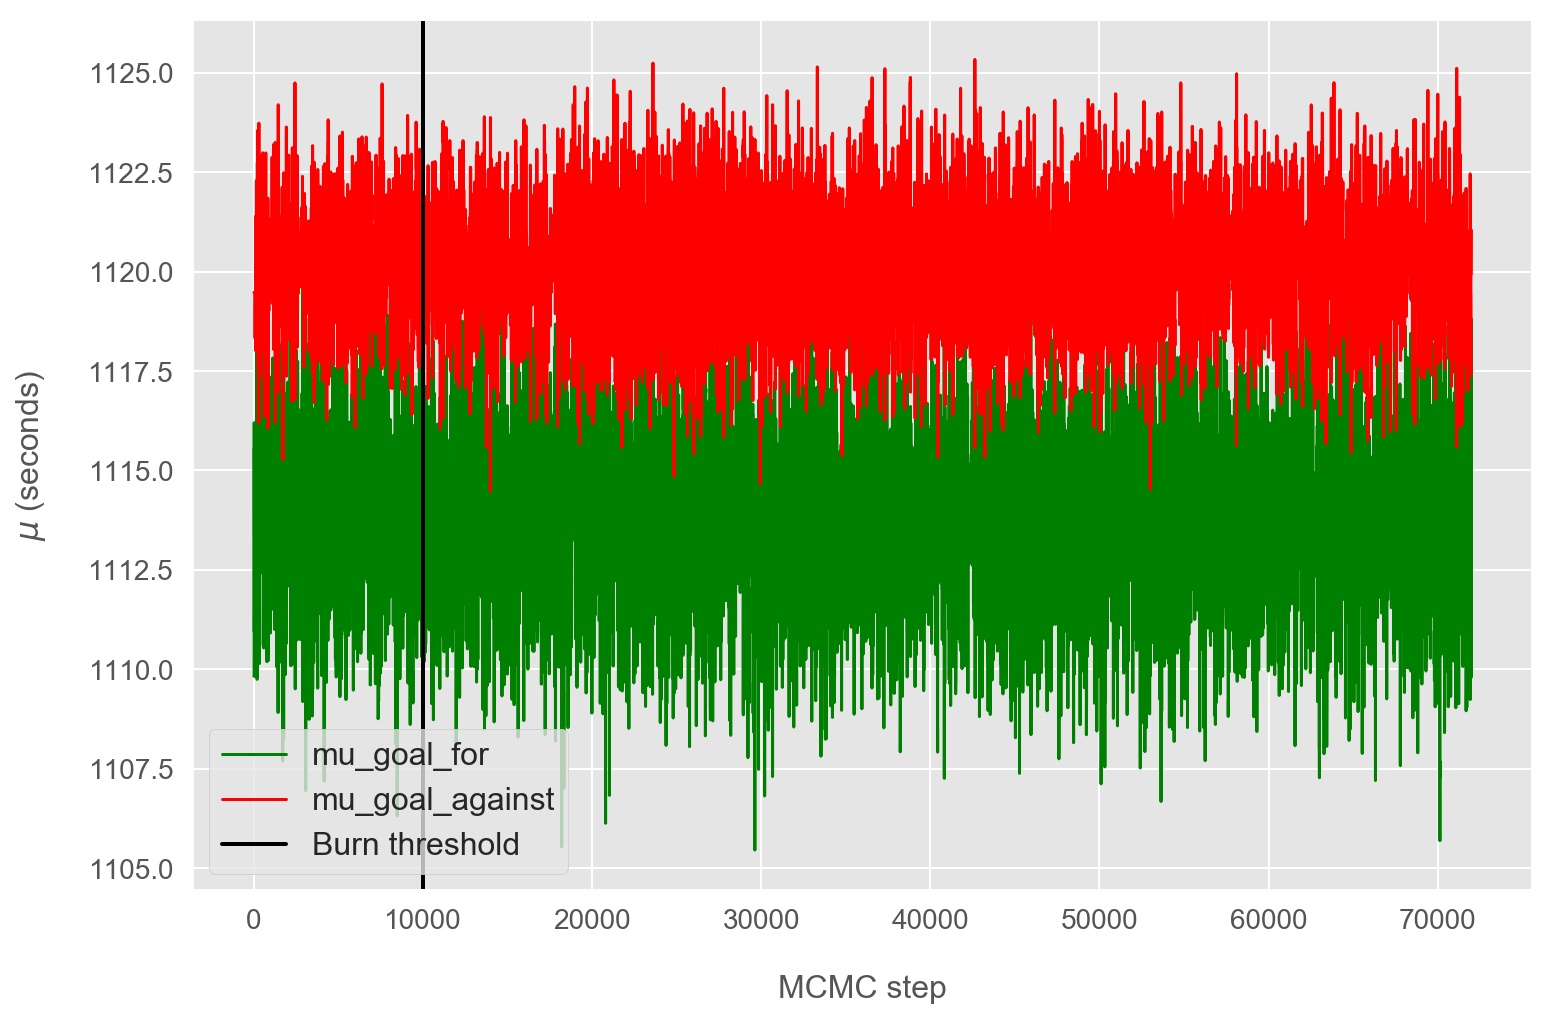

In [100]:
plt.plot(trace['mu_goal_for'], label='mu_goal_for', color='green')
plt.plot(trace['mu_goal_against'], label='mu_goal_against', color='red')
plt.ylabel('$\mu$ (seconds)')
plt.xlabel('MCMC step')

plt.axvline(N_burn, color='black', lw=2, label='Burn threshold')

plt.legend();

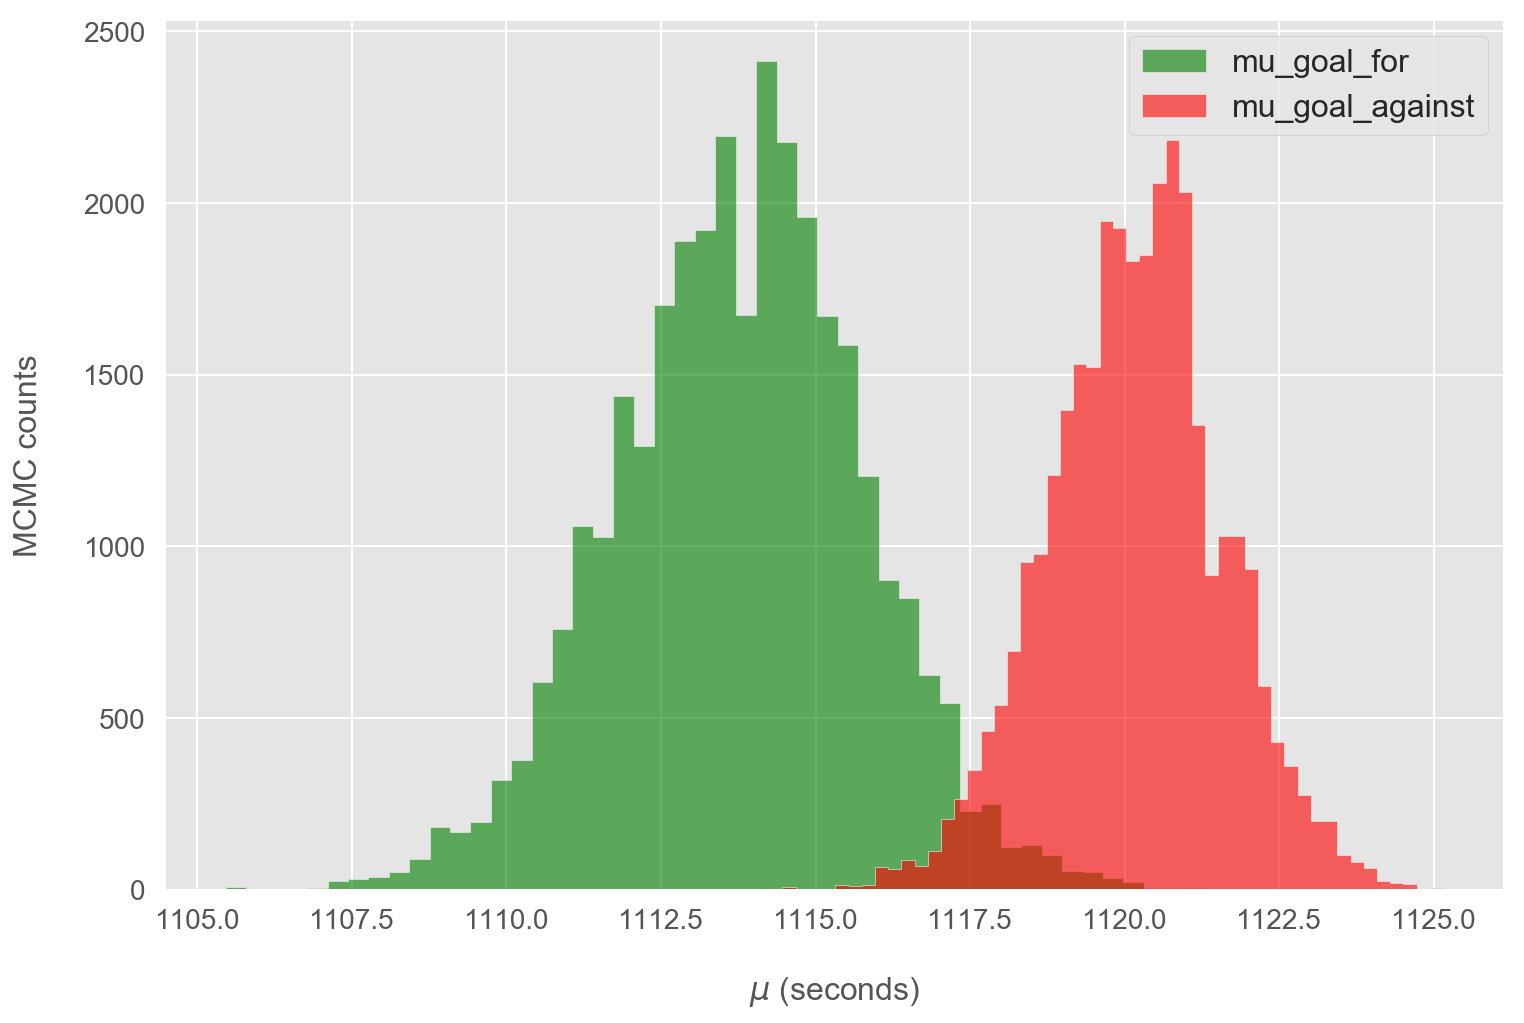

In [101]:
ALPHA = 0.6

plt.hist(burned_trace['mu_goal_for'], bins=50,
         color='green', label='mu_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_goal_against'], bins=50,
         color='red', label='mu_goal_against',
         histtype='stepfilled', alpha=ALPHA)
plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (seconds)')
plt.legend();

In [26]:
ALPHA = 0.6

plt.hist(burned_trace['p_goal_for'], bins=50,
         color='green', label='p_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against'], bins=50,
         color='red', label='p_goal_against',
         histtype='stepfilled', alpha=ALPHA)

plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (seconds)')
plt.legend();

KeyError: 'Unknown variable p_goal_for'



Adding a contraint:

```_equation = pm.math.eq(p_goal_for + p_goal_against, 1)
constraint = pm.Potential(
    'constraint',
    pm.math.switch(_equation, 0, -np.inf)
)```

In [29]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Model() as model:

        # Observations to train the model
        obs_goal_for = pm.Poisson(
            'obs_goal_for',
            mu=training_samples[0].mean(),
            observed=training_samples[0],
        )
        obs_goal_against = pm.Poisson(
            'obs_goal_against',
            mu=training_samples[1].mean(),
            observed=training_samples[1],
        )
        
        # Priors for the mu parameter of the
        # Poisson distribution.
        # Note that mu = mean(Poisson)
        mu_goal_for = pm.Uniform(
            'mu_goal_for', 15*60, 20*60
        )
        mu_goal_against = pm.Uniform(
            'mu_goal_against', 15*60, 20*60
        )
        
        # Goal probabilities
        p_goal_for = pm.Poisson(
            'p_goal_for', mu_goal_for
        )
        p_goal_against = pm.Poisson(
            'p_goal_against', mu_goal_against
        )
        
        # Constraint on probabilties
        # Add 
        _equation = pm.math.eq(p_goal_for + p_goal_against, 1)
        constraint = pm.Potential(
            'constraint',
            pm.math.switch(_equation, 0, -np.inf)
        )

        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_goal_against]
>Metropolis: [p_goal_for]
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:17<00:00, 4320.76draws/s]


In [30]:
N_burn = 10000
burned_trace = trace[N_burn:]

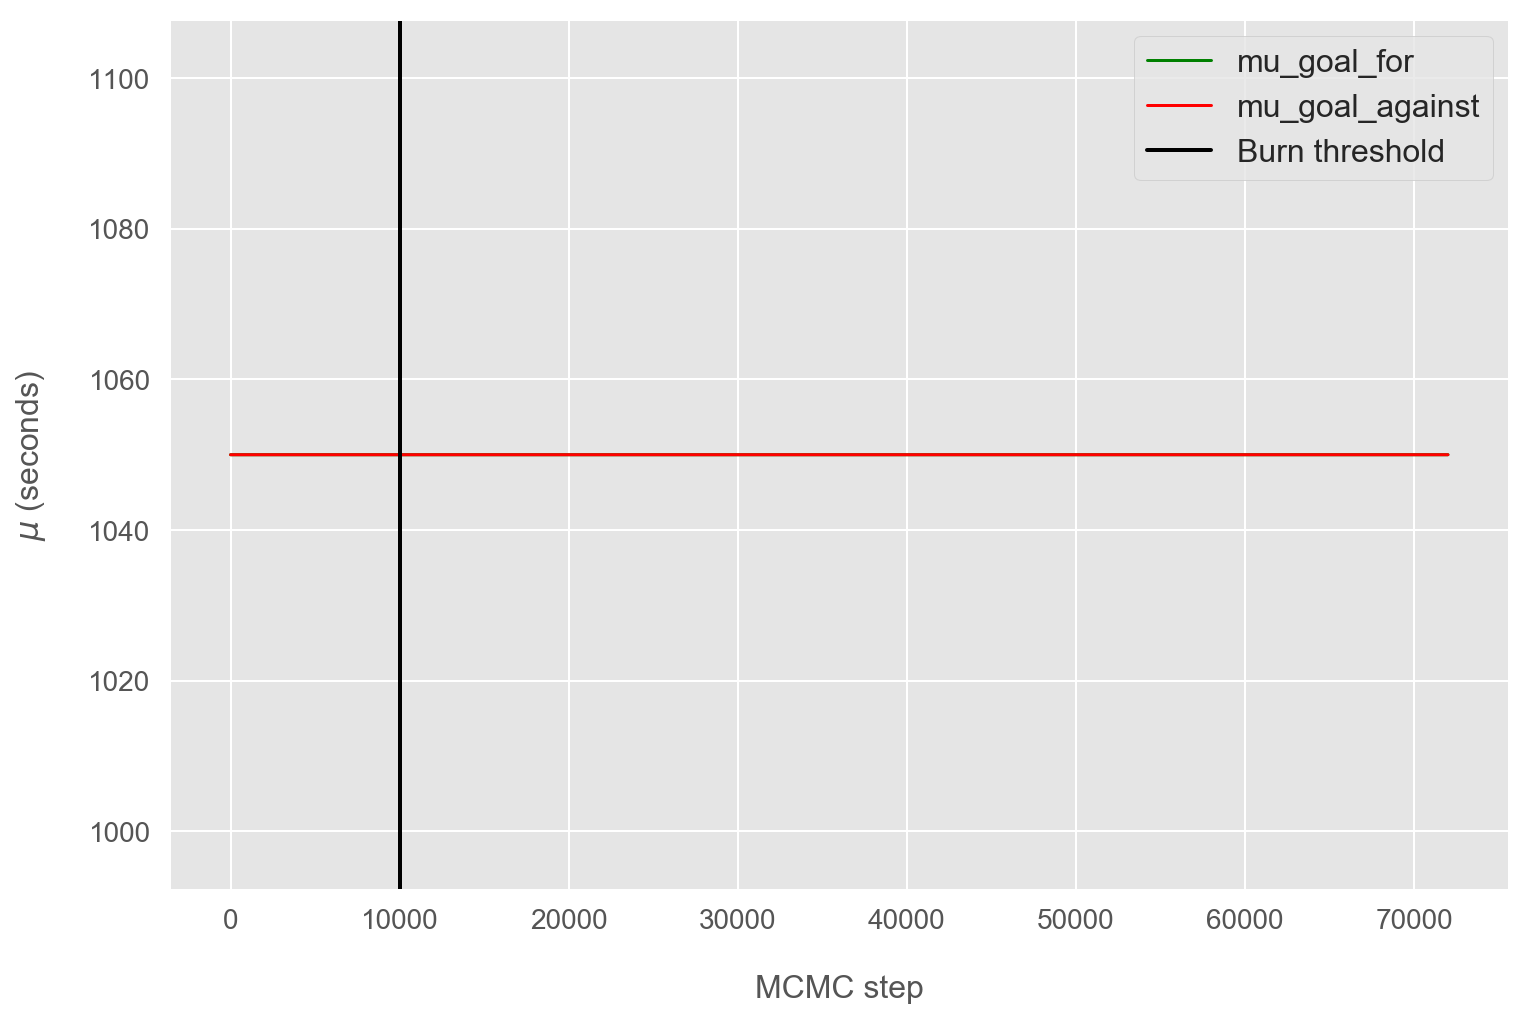

In [31]:
plt.plot(trace['mu_goal_for'], label='mu_goal_for', color='green')
plt.plot(trace['mu_goal_against'], label='mu_goal_against', color='red')
plt.ylabel('$\mu$ (seconds)')
plt.xlabel('MCMC step')

plt.axvline(N_burn, color='black', lw=2, label='Burn threshold')

plt.legend();

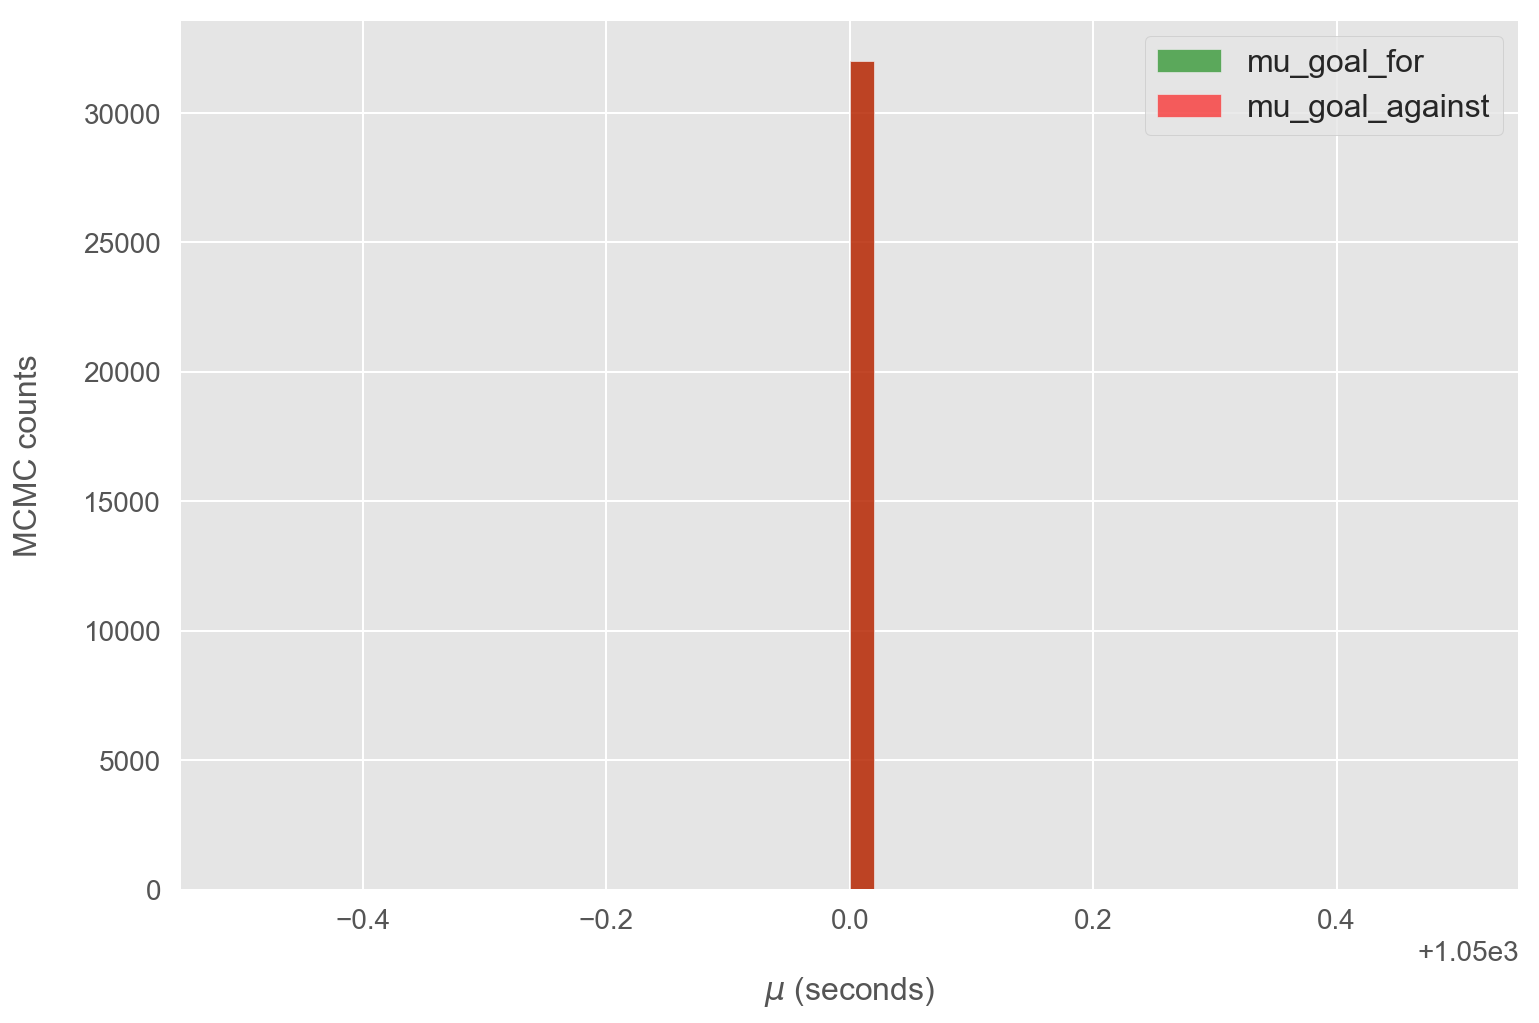

In [32]:
ALPHA = 0.6

plt.hist(burned_trace['mu_goal_for'], bins=50,
         color='green', label='mu_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_goal_against'], bins=50,
         color='red', label='mu_goal_against',
         histtype='stepfilled', alpha=ALPHA)
plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (seconds)')
plt.legend();

In [26]:
ALPHA = 0.6

plt.hist(burned_trace['p_goal_for'], bins=50,
         color='green', label='p_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against'], bins=50,
         color='red', label='p_goal_against',
         histtype='stepfilled', alpha=ALPHA)

plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (seconds)')
plt.legend();

KeyError: 'Unknown variable p_goal_for'

That didnt work too well...

But we're getting closer to the final model

---

#### Including "no goals" variable

Lets make them bounded and add in the game end var

In [37]:
df.columns

Index(['season', 'game_number', 'team_name', 'date', 'pull_period',
       'pull_time', 'goal_for_time', 'goal_against_time', 'goal_for_timedelta',
       'goal_against_timedelta', 'game_end_timedelta'],
      dtype='object')

In [38]:
# Load time of pull for eventual outcomes:
feature_names = ['goal_for', 'goal_against', 'no_goals']

# Logic for loading the data
features = ['pull_time', 'pull_time', 'pull_time']
masks = [
    ~(df.goal_for_time.isnull()),
    ~(df.goal_against_time.isnull()),
    (df.goal_for_time.isnull() & df.goal_against_time.isnull()),
]
training_samples = load_training_samples(df, features, masks)

Loaded 270 samples for col pull_time
Loaded 554 samples for col pull_time
Loaded 1305 samples for col pull_time
Training data shape = (3,)


In [39]:
(training_samples[0][:10],
training_samples[1][:10],
training_samples[2][:10],)

(array([1119., 1114., 1109., 1111., 1081., 1121., 1100., 1103., 1145.,
        1142.]),
 array([1184., 1143., 1168., 1133., 1133., 1140., 1118., 1130., 1148.,
        1104.]),
 array([1198., 1125., 1068., 1151., 1119., 1137., 1131., 1140., 1192.,
        1137.]))

Trying constrained model again

In [195]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Model() as model:

        # Priors for the mu parameter of the
        # Poisson distribution P.
        # Note: mu = mean(P)
        mu_goal_for = pm.Uniform(
            'mu_goal_for', 15*60, 20*60
        )
        mu_goal_against = pm.Uniform(
            'mu_goal_against', 15*60, 20*60
        )
        mu_no_goal = pm.Uniform(
            'mu_no_goal', 15*60, 20*60
        )
        
        # Observations to train the model on
        obs_goal_for = pm.Poisson(
            'obs_goal_for',
            mu=mu_goal_for,
            observed=training_samples[0],
        )
        obs_goal_against = pm.Poisson(
            'obs_goal_against',
            mu=mu_goal_against,
            observed=training_samples[1],
        )
        obs_no_goal = pm.Poisson(
            'obs_no_goal',
            mu=mu_no_goal,
            observed=training_samples[2],
        )
        
        # Outcome probabilities
        p_goal_for = pm.Bound(pm.Poisson, upper=20*60)('p_goal_for', mu=mu_goal_for)
        p_goal_against = pm.Bound(pm.Poisson, upper=20*60)('p_goal_against', mu=mu_goal_against)
        p_no_goal = pm.Bound(pm.Poisson, upper=20*60)('p_no_goal', mu=mu_no_goal)
        
        # Constraint on probabilties
        _equation = pm.math.eq(p_goal_for + p_goal_against + p_no_goal, 1)
        constraint = pm.Potential(
            'constraint',
            pm.math.switch(_equation, 0, -np.inf)
        )
        
        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_no_goal]
>Metropolis: [p_goal_against]
>Metropolis: [p_goal_for]
>Metropolis: [mu_no_goal]
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:24<00:00, 2965.49draws/s]


In [196]:
N_burn = 10000
burned_trace = trace[N_burn:]

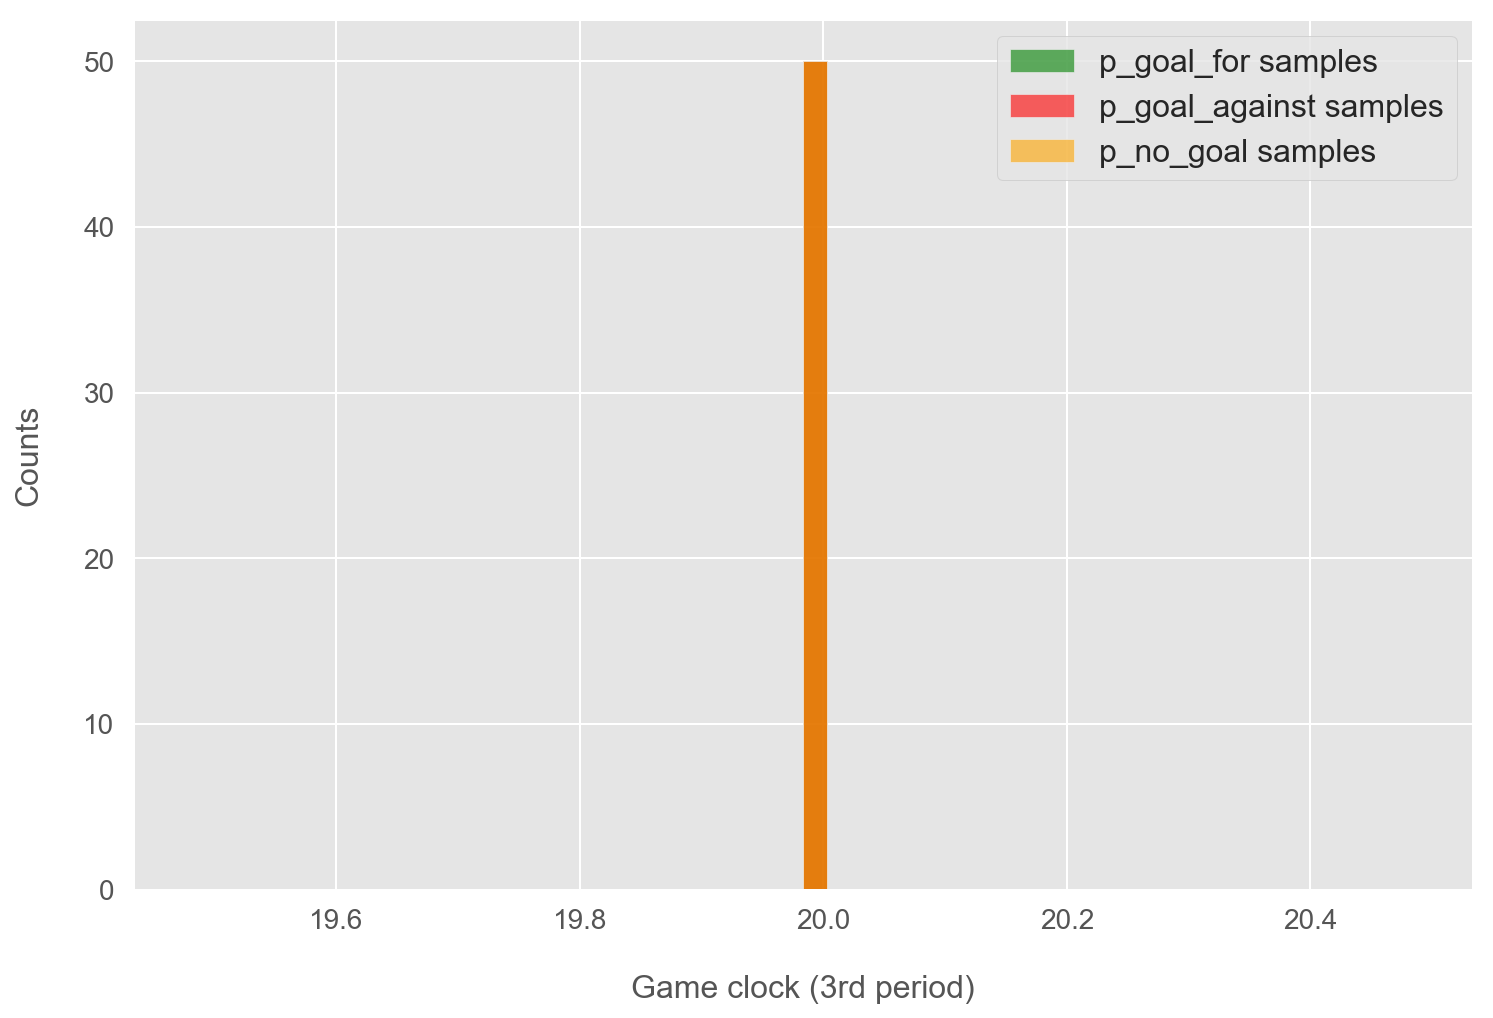

In [198]:
ALPHA = 0.6
LW = 3

from scipy.stats import poisson

# plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
#          color='green', label=r'$P(\rm{goal\;for}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

# plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
#          color='red', label=r'$P(\rm{goal\;against}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

''' Plot the MCMC samples '''

plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
         color='green', label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
         color='red', label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_no_goal'] / 60, bins=50,
         color='orange', label='p_no_goal samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

''' Plot the poisson distributions '''

# p = poisson.pmf
# x = np.arange(16*60, 22*60, 1)
# mu_goal_for = burned_trace['mu_goal_for'].mean()
# mu_goal_against = burned_trace['mu_goal_against'].mean()
# mu_no_goal = burned_trace['mu_no_goal'].mean()
# y_goal_for = p(x, mu_goal_for)
# y_goal_against = p(x, mu_goal_against)
# y_no_goal = p(x, mu_no_goal)

# # Convert into minutes and rescale to fit chart
# x = x / 60
# scale_frac = 0.7
# y_goal_for = y_goal_for / y_goal_for.max() * scale_frac
# y_goal_against = y_goal_against / y_goal_against.max() * scale_frac
# y_no_goal = y_no_goal / y_no_goal.max() * scale_frac

# plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{MCMC})$', color='green', lw=LW)
# plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{MCMC})$', color='red', lw=LW)
# plt.plot(x, y_no_goal, label=r'$P(\rm{no\;goal};\mu_{MCMC})$', color='orange', lw=LW)

plt.ylabel('Counts')
# plt.yticks([])
plt.xlabel('Game clock (3rd period)')
plt.legend();
plt.show()

Constraints just don't make sense here...

Removing them.

In [200]:
def bayes_model(training_samples) -> pm.model.Model:
    """
    Solve for posterior distributions using pymc3
    """
    with pm.Model() as model:

        # Priors for the mu parameter of the
        # Poisson distribution P.
        # Note: mu = mean(P)
        mu_goal_for = pm.Uniform(
            'mu_goal_for', 15*60, 20*60
        )
        mu_goal_against = pm.Uniform(
            'mu_goal_against', 15*60, 20*60
        )
        mu_no_goal = pm.Uniform(
            'mu_no_goal', 15*60, 20*60
        )
        
        # Observations to train the model on
        obs_goal_for = pm.Poisson(
            'obs_goal_for',
            mu=mu_goal_for,
            observed=training_samples[0],
        )
        obs_goal_against = pm.Poisson(
            'obs_goal_against',
            mu=mu_goal_against,
            observed=training_samples[1],
        )
        obs_no_goal = pm.Poisson(
            'obs_no_goal',
            mu=mu_no_goal,
            observed=training_samples[2],
        )
        
        # Outcome probabilities
        p_goal_for = pm.Bound(pm.Poisson, upper=20*60)('p_goal_for', mu=mu_goal_for)
        p_goal_against = pm.Bound(pm.Poisson, upper=20*60)('p_goal_against', mu=mu_goal_against)
        p_no_goal = pm.Bound(pm.Poisson, upper=20*60)('p_no_goal', mu=mu_no_goal)
        
        # Fit model
        step = pm.Metropolis()
        trace = pm.sample(18000, step=step)
        
    return model, trace

model, trace = bayes_model(training_samples)
model

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_no_goal]
>Metropolis: [p_goal_against]
>Metropolis: [p_goal_for]
>Metropolis: [mu_no_goal]
>Metropolis: [mu_goal_against]
>Metropolis: [mu_goal_for]
Sampling 4 chains: 100%|██████████| 74000/74000 [00:28<00:00, 2618.98draws/s]
The number of effective samples is smaller than 10% for some parameters.


In [201]:
N_burn = 10000
burned_trace = trace[N_burn:]

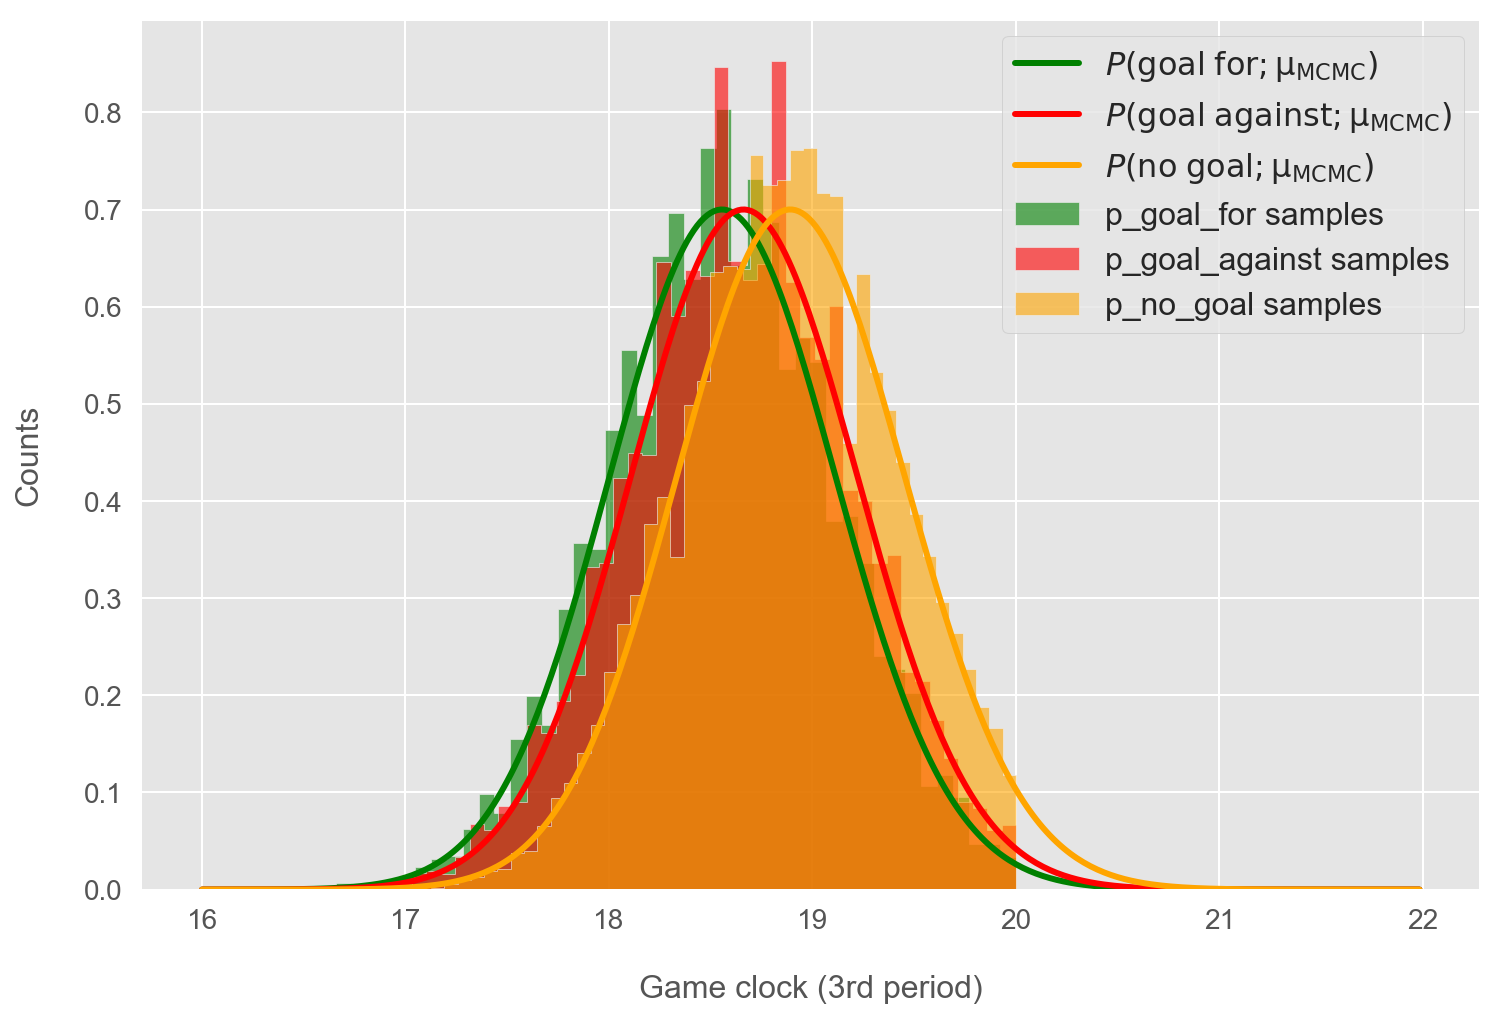

In [202]:
ALPHA = 0.6
LW = 3

from scipy.stats import poisson

# plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
#          color='green', label=r'$P(\rm{goal\;for}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

# plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
#          color='red', label=r'$P(\rm{goal\;against}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

''' Plot the MCMC samples '''

plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
         color='green', label='p_goal_for samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
         color='red', label='p_goal_against samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['p_no_goal'] / 60, bins=50,
         color='orange', label='p_no_goal samples',
         density='normed',
         histtype='stepfilled', alpha=ALPHA)

''' Plot the poisson distributions '''

p = poisson.pmf
x = np.arange(16*60, 22*60, 1)
mu_goal_for = burned_trace['mu_goal_for'].mean()
mu_goal_against = burned_trace['mu_goal_against'].mean()
mu_no_goal = burned_trace['mu_no_goal'].mean()
y_goal_for = p(x, mu_goal_for)
y_goal_against = p(x, mu_goal_against)
y_no_goal = p(x, mu_no_goal)

# Convert into minutes and rescale to fit chart
x = x / 60
scale_frac = 0.7
y_goal_for = y_goal_for / y_goal_for.max() * scale_frac
y_goal_against = y_goal_against / y_goal_against.max() * scale_frac
y_no_goal = y_no_goal / y_no_goal.max() * scale_frac

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{MCMC})$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{MCMC})$', color='red', lw=LW)
plt.plot(x, y_no_goal, label=r'$P(\rm{no\;goal};\mu_{MCMC})$', color='orange', lw=LW)

plt.ylabel('Counts')
# plt.yticks([])
plt.xlabel('Game clock (3rd period)')
plt.legend();
plt.show()

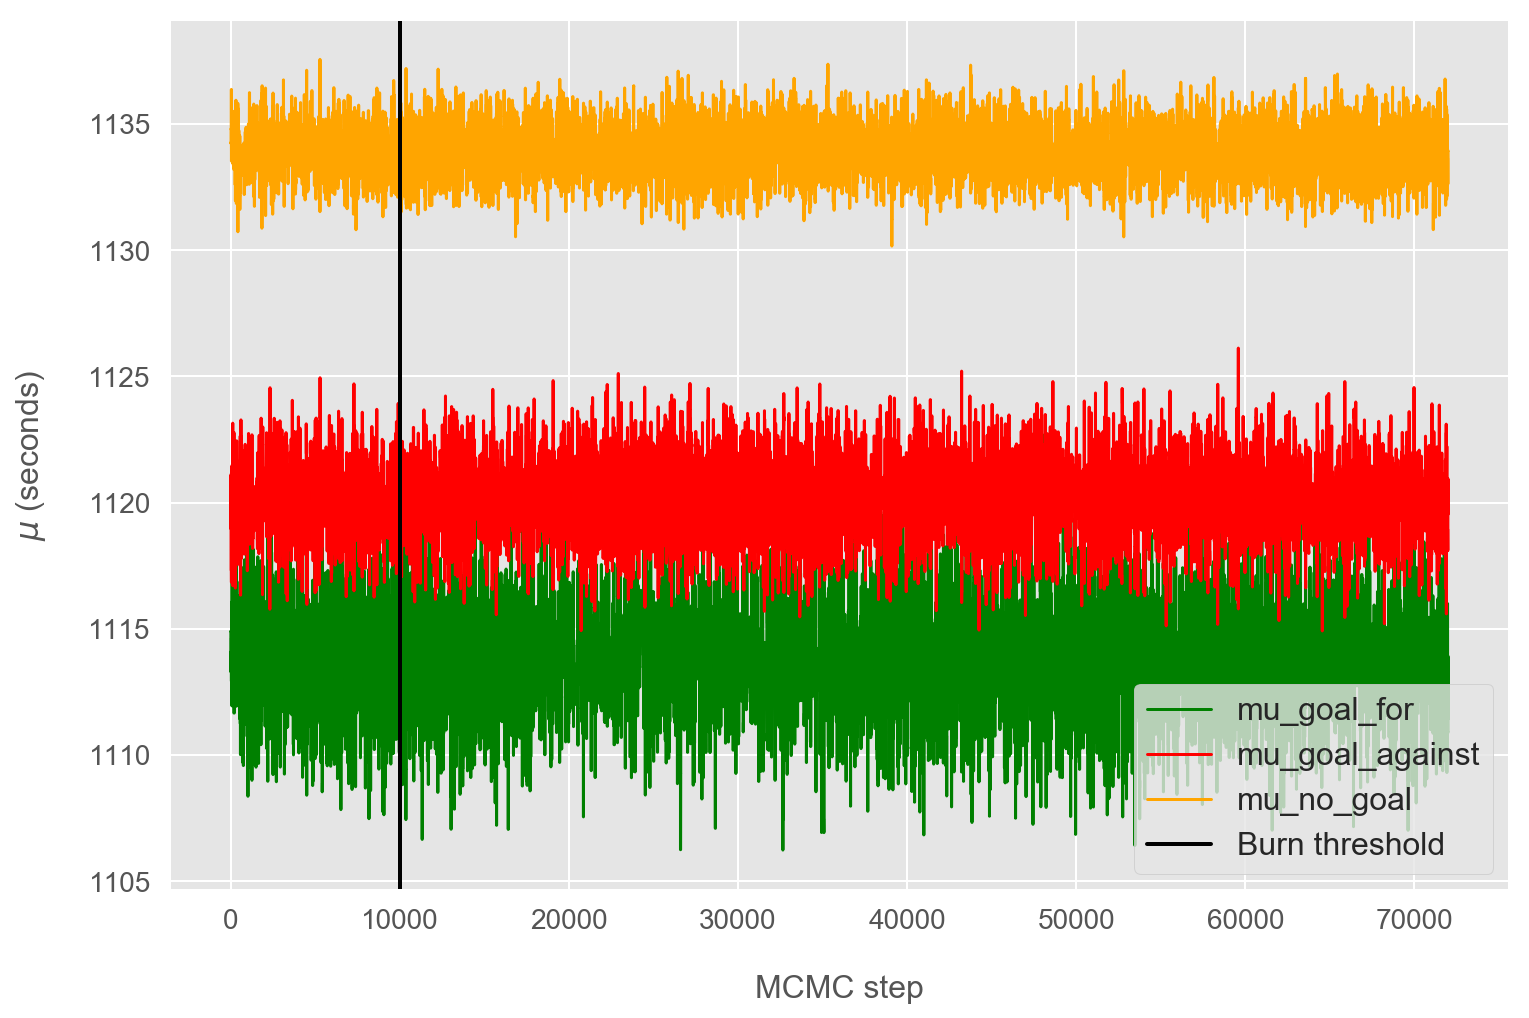

In [203]:
plt.plot(trace['mu_goal_for'], label='mu_goal_for', color='green')
plt.plot(trace['mu_goal_against'], label='mu_goal_against', color='red')
plt.plot(trace['mu_no_goal'], label='mu_no_goal', color='orange')
plt.ylabel('$\mu$ (seconds)')
plt.xlabel('MCMC step')

plt.axvline(N_burn, color='black', lw=2, label='Burn threshold')

plt.legend();

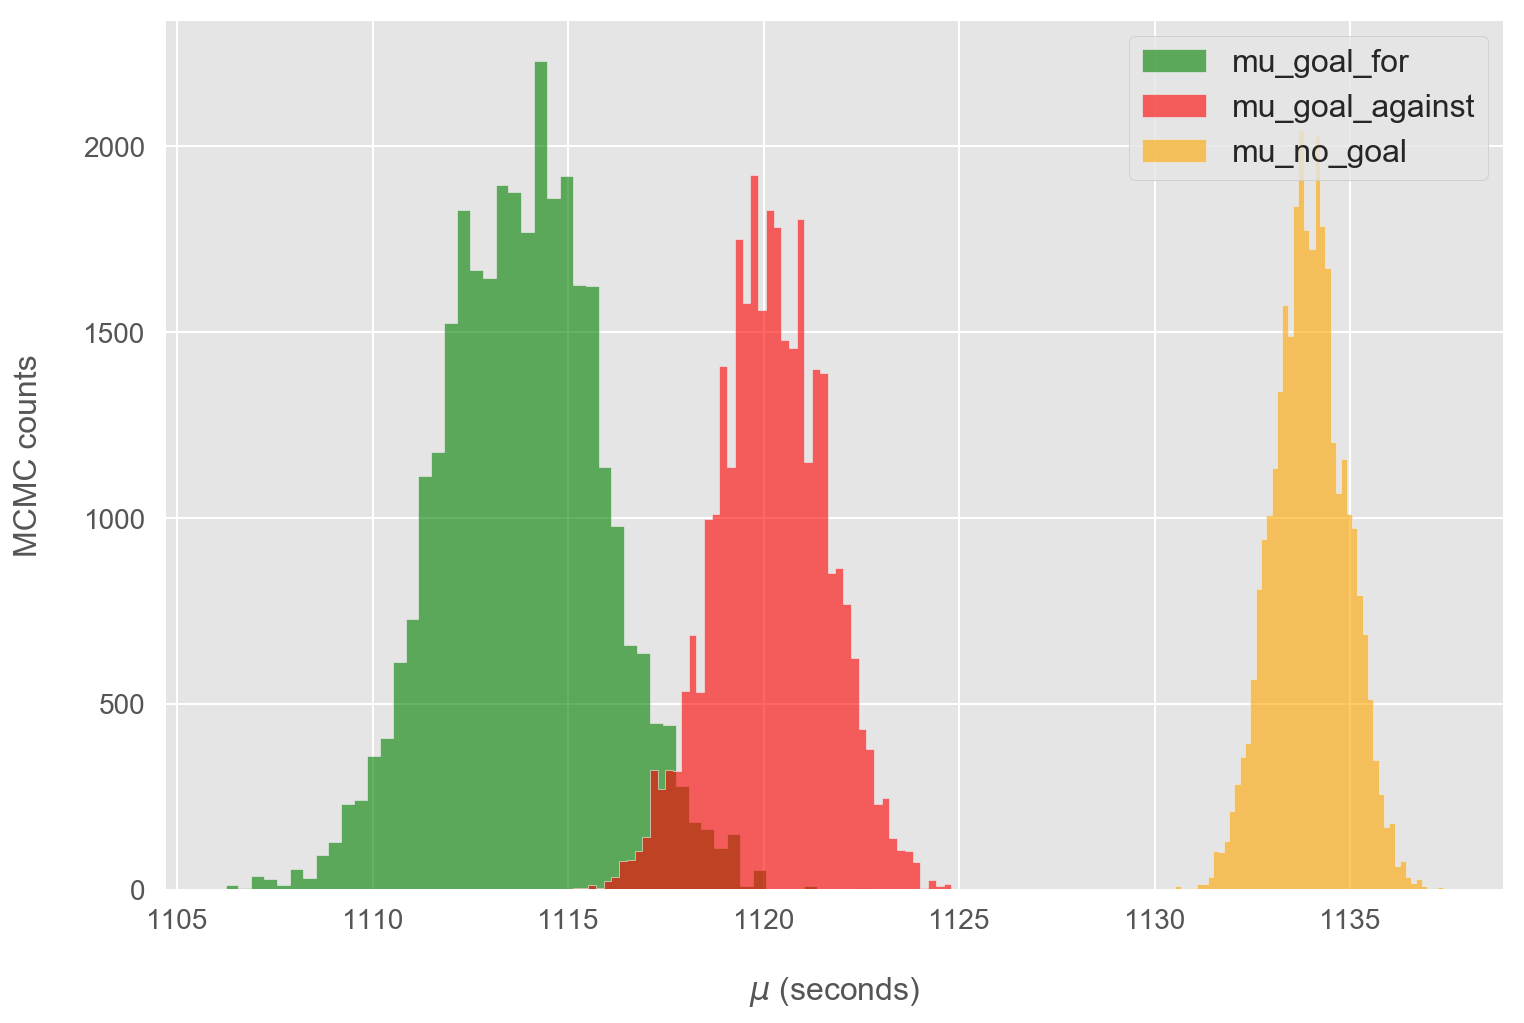

In [204]:
ALPHA = 0.6

plt.hist(burned_trace['mu_goal_for'], bins=50,
         color='green', label='mu_goal_for',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_goal_against'], bins=50,
         color='red', label='mu_goal_against',
         histtype='stepfilled', alpha=ALPHA)

plt.hist(burned_trace['mu_no_goal'], bins=50,
         color='orange', label='mu_no_goal',
         histtype='stepfilled', alpha=ALPHA)

plt.ylabel('MCMC counts')
plt.xlabel('$\mu$ (seconds)')
plt.legend();

Now I need to normalize these guys. I looks like they don't have an even number of samples... let's check on that

In [205]:
(burned_trace['mu_goal_for'].shape,
burned_trace['mu_goal_against'].shape,
burned_trace['mu_no_goal'].shape)

((32000,), (32000,), (32000,))

In [206]:
len(burned_trace) * 4

32000

Nice! Same number of samlpes. Weird that it's 4x my burned trace - probably due to 4 cores

In [207]:
normed_factors = np.array([
    training_samples[0].shape,
     training_samples[1].shape,
     training_samples[2].shape
])
normed_factors = normed_factors / normed_factors.sum()
normed_factors

array([[0.1268201 ],
       [0.26021606],
       [0.61296383]])

Those ^ are the normalizing class probabilties

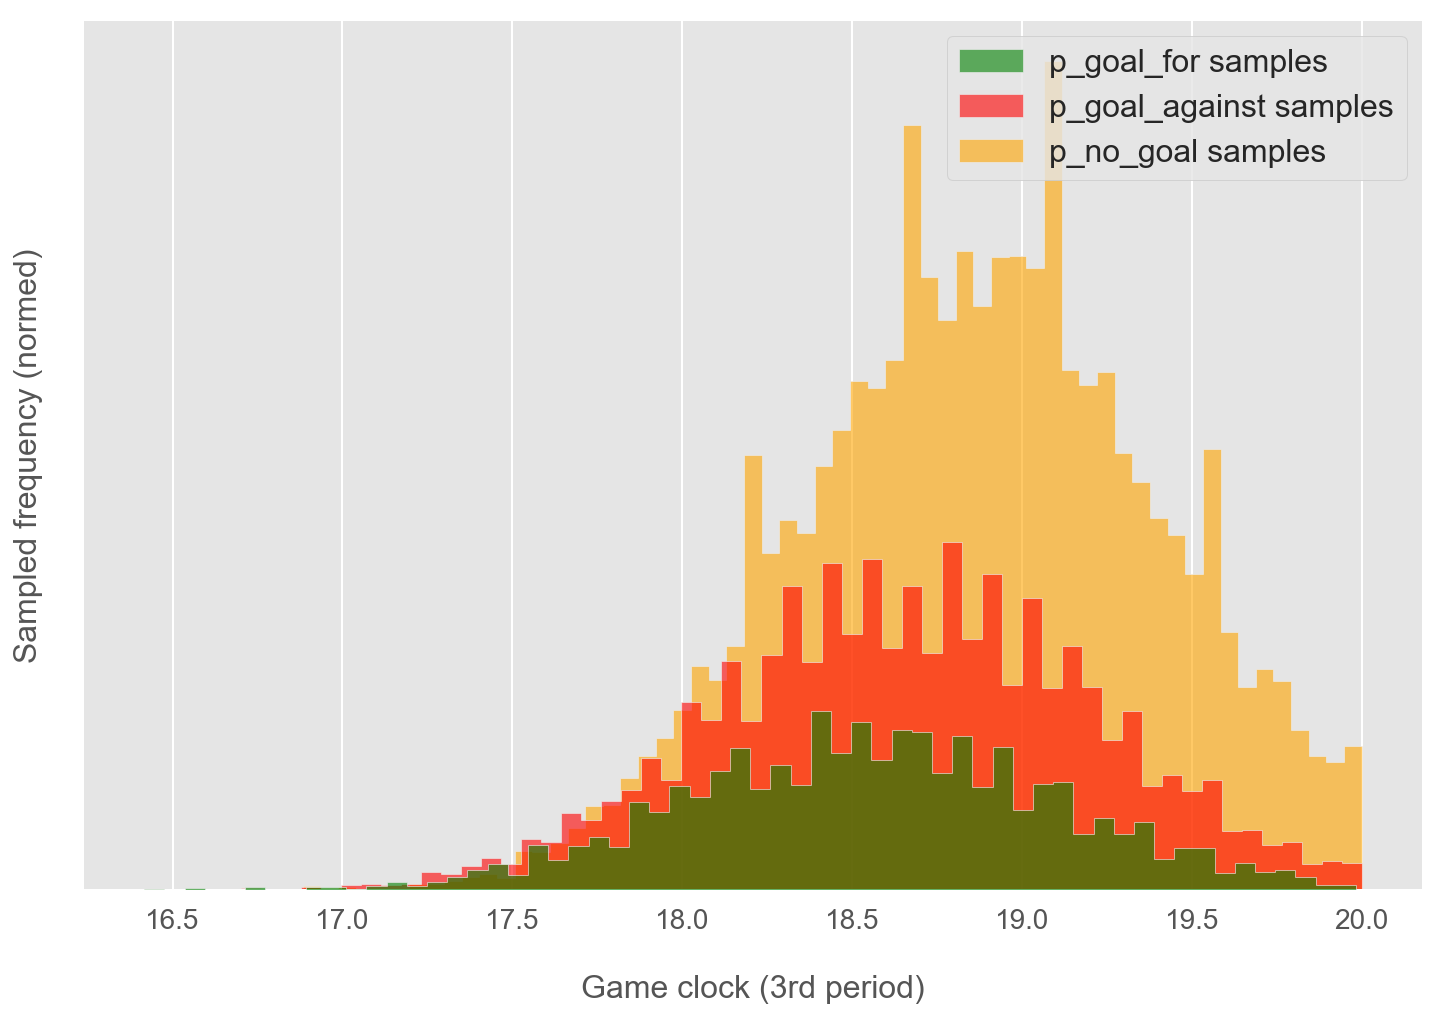

In [208]:
ALPHA = 0.6
LW = 3
BINS = 60

# plt.hist(burned_trace['p_goal_for'] / 60, bins=50,
#          color='green', label=r'$P(\rm{goal\;for}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

# plt.hist(burned_trace['p_goal_against'] / 60, bins=50,
#          color='red', label=r'$P(\rm{goal\;against}\;|\;\rm{goalie\;pulled})$',
#          histtype='stepfilled', alpha=ALPHA)

''' Plot the MCMC samples '''

plt.hist(np.random.choice(
            burned_trace['p_goal_for'] / 60,
            size=int(burned_trace['p_goal_for'].shape[0] * normed_factors[0])
         ),
         bins=BINS, color='green', label='p_goal_for samples',
#          density='normed',
         histtype='stepfilled', alpha=ALPHA, zorder=3)

plt.hist(np.random.choice(
            burned_trace['p_goal_against'] / 60,
            size=int(burned_trace['p_goal_against'].shape[0] * normed_factors[1])
         ),
         bins=BINS,
         color='red', label='p_goal_against samples',
#          density='normed',
         histtype='stepfilled', alpha=ALPHA, zorder=2)

plt.hist(np.random.choice(
            burned_trace['p_no_goal'] / 60,
            size=int(burned_trace['p_no_goal'].shape[0] * normed_factors[2])
         ),
         bins=BINS,
         color='orange', label='p_no_goal samples',
#          density='normed',
         histtype='stepfilled', alpha=ALPHA)

plt.ylabel('Sampled frequency (normed)')
plt.yticks([])
plt.xlabel('Game clock (3rd period)')
plt.legend();
plt.show()

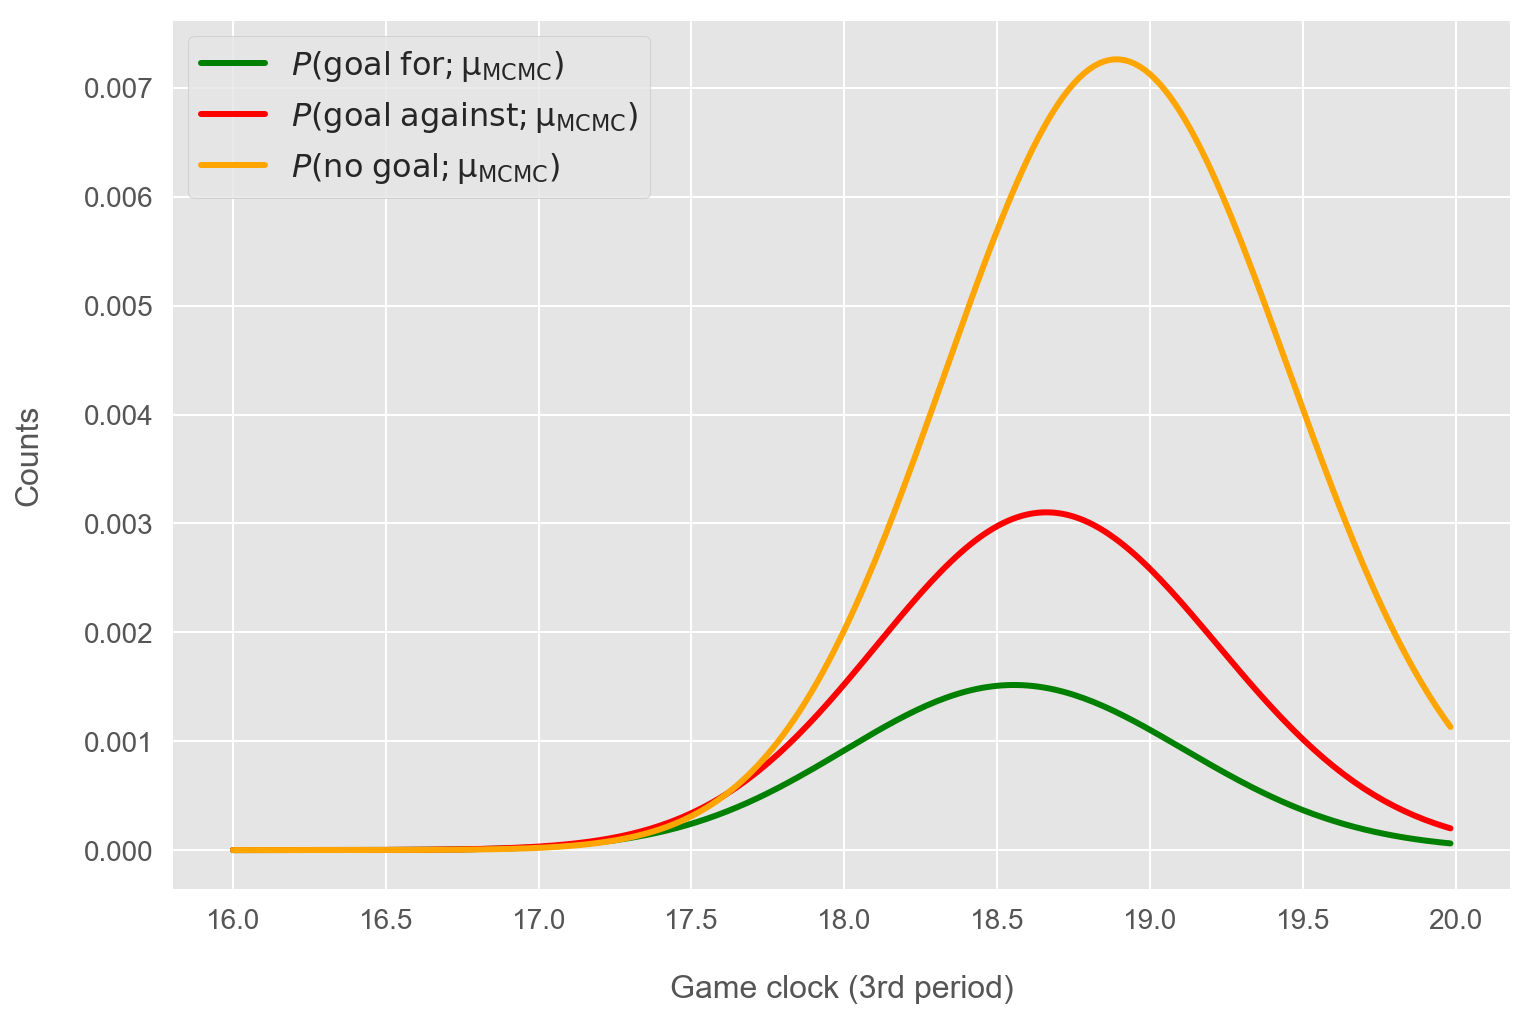

In [209]:
from scipy.stats import poisson
ALPHA = 0.6
LW = 3

''' Plot the poisson distributions '''

p = poisson.pmf
x = np.arange(16*60, 20*60, 1)
mu_goal_for = burned_trace['mu_goal_for'].mean()
mu_goal_against = burned_trace['mu_goal_against'].mean()
mu_no_goal = burned_trace['mu_no_goal'].mean()
y_goal_for = p(x, mu_goal_for) * normed_factors[0]
y_goal_against = p(x, mu_goal_against) * normed_factors[1]
y_no_goal = p(x, mu_no_goal) * normed_factors[2]

# Convert into minutes and rescale to fit chart
x = x / 60
# scale_frac = 0.7
# y_goal_for = y_goal_for / y_goal_for.max() * normed_factors[0]
# y_goal_against = y_goal_against / y_goal_against.max() * normed_factors[1]
# y_no_goal = y_no_goal / y_no_goal.max() * normed_factors[2]

plt.plot(x, y_goal_for, label=r'$P(\rm{goal\;for};\mu_{MCMC})$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\rm{goal\;against};\mu_{MCMC})$', color='red', lw=LW)
plt.plot(x, y_no_goal, label=r'$P(\rm{no\;goal};\mu_{MCMC})$', color='orange', lw=LW)

plt.ylabel('Counts')
# plt.yticks([])
plt.xlabel('Game clock (3rd period)')
plt.legend();
plt.show()

In [210]:
y_goal_for.sum() + y_goal_against.sum() + y_no_goal.sum()

0.9805385873362338

This is less than 1 because I cut off the tail..

We can easily **correct for this by renormalizing**

In [211]:
cutoff_renormed_factor = 2 - (y_goal_for.sum() + y_goal_against.sum() + y_no_goal.sum())
cutoff_renormed_factor

1.0194614126637662

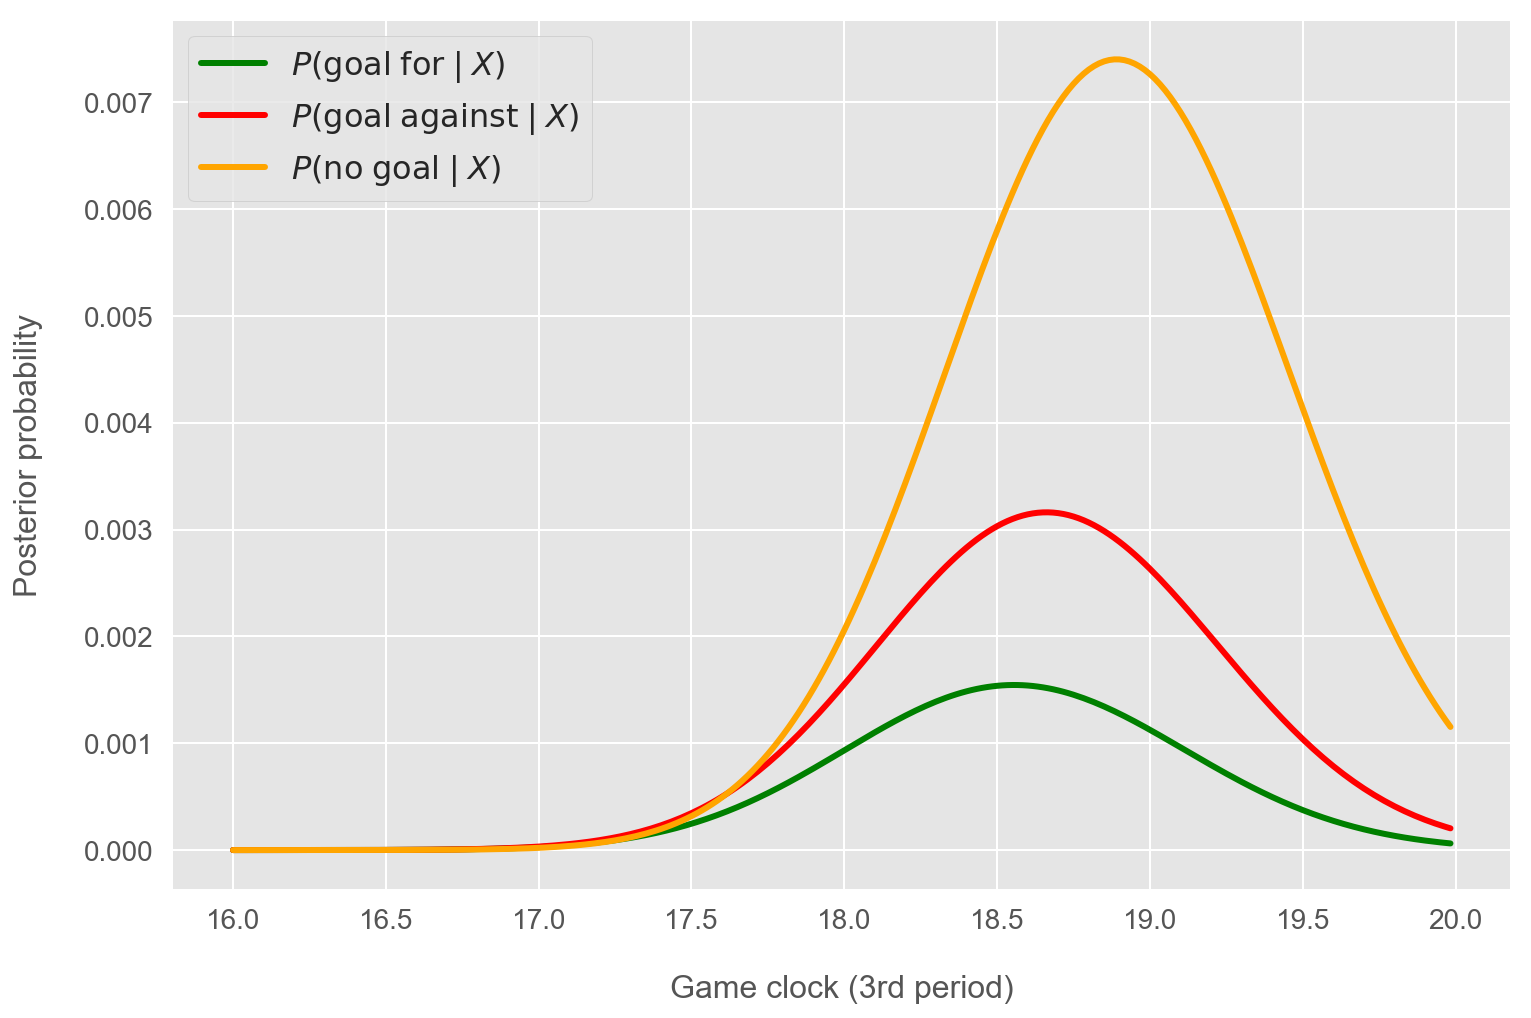

In [212]:
from scipy.stats import poisson
ALPHA = 0.6
LW = 3 

''' Plot the poisson distributions '''

p = poisson.pmf
x = np.arange(16*60, 20*60, 1)
mu_goal_for = burned_trace['mu_goal_for'].mean()
mu_goal_against = burned_trace['mu_goal_against'].mean()
mu_no_goal = burned_trace['mu_no_goal'].mean()
y_goal_for = p(x, mu_goal_for) * normed_factors[0]
y_goal_against = p(x, mu_goal_against) * normed_factors[1]
y_no_goal = p(x, mu_no_goal) * normed_factors[2]
cutoff_renormed_factor = 2 - (y_goal_for.sum() + y_goal_against.sum() + y_no_goal.sum())
y_goal_for = y_goal_for * cutoff_renormed_factor
y_goal_against = y_goal_against * cutoff_renormed_factor
y_no_goal = y_no_goal * cutoff_renormed_factor

# Convert into minutes and rescale to fit chart
x = x / 60
# scale_frac = 0.7
# y_goal_for = y_goal_for / y_goal_for.max() * normed_factors[0]
# y_goal_against = y_goal_against / y_goal_against.max() * normed_factors[1]
# y_no_goal = y_no_goal / y_no_goal.max() * normed_factors[2]

plt.plot(x, y_goal_for, label=r'$P(\mathrm{goal\;for}\;|\;X)$', color='green', lw=LW)
plt.plot(x, y_goal_against, label=r'$P(\mathrm{goal\;against}\;|\;X)$', color='red', lw=LW)
plt.plot(x, y_no_goal, label=r'$P(\mathrm{no\;goal}\;|\;X)$', color='orange', lw=LW)

plt.ylabel('Posterior probability')
# plt.yticks([])
plt.xlabel('Game clock (3rd period)')
plt.legend();
plt.show()

In [213]:
y_goal_for.sum() + y_goal_against.sum() + y_no_goal.sum()

0.9996212534171306

In [214]:
print(f'Final normalizing factors =\n{normed_factors * cutoff_renormed_factor}')

Final normalizing factors =
[[0.1292882 ]
 [0.26528024]
 [0.62489297]]


In [220]:
mu_mcmc = [
    burned_trace['mu_goal_for'].mean(),
    burned_trace['mu_goal_against'].mean(),
    burned_trace['mu_no_goal'].mean(),
]

print(f'Final values for mu: {mu_mcmc}')

Final values for mu: [1113.8279468130681, 1120.1830172722719, 1133.9420018554083]


In [215]:
def convert_to_time_remaining(x):
    _x = 20 - x
    t = datetime.timedelta(seconds=_x*60)
    return str(t)

convert_to_time_remaining(x[np.argmax(y_goal_for)])

'0:01:27'

In [216]:
print('Time of max posterior probability =\n'
      f'{x[np.argmax(y_goal_for)], x[np.argmax(y_goal_against)], x[np.argmax(y_no_goal)]}')

print()

t_remaining = [convert_to_time_remaining(x[np.argmax(y_goal_for)]),
              convert_to_time_remaining(x[np.argmax(y_goal_against)]),
              convert_to_time_remaining(x[np.argmax(y_no_goal)])]

print(f'Time of max posterior probability =\n{t_remaining}')

Time of max posterior probability =
(18.55, 18.666666666666668, 18.883333333333333)

Time of max posterior probability =
['0:01:27', '0:01:20', '0:01:07']


Great, now we have properly normalized probabilties.

Notes:
 - From normalizing factors, we can see ~12% chance of scoring when pulling the goalie on average.
 - Probability of scoring peaks at 18.55 mins (1:27 remaining), with other probabilties following close after (01:20 for goal against and 01:07 for no goals)

From now on we'll work from the distributions as our source of truth.

Let's plot the cumulative distribution.

In [ ]:



model_normlizing_factors = (normed_factors * cutoff_renormed_factor).flatten()

mu_mcmc = [
    burned_trace['mu_goal_for'].mean(),
    burned_trace['mu_goal_against'].mean(),
    burned_trace['mu_no_goal'].mean(),
]

In [218]:

model_normlizing_factors = [
    0.1292882,
    0.26528024,
    0.62489297,
]

mu_mcmc = [
    1113.8279468130681,
    1120.1830172722719,
    1133.9420018554083
]

from scipy.stats import poisson
p = poisson.pmf

x = np.arange(16*60, 20*60, 1)
mu_goal_for = burned_trace['mu_goal_for'].mean()
mu_goal_against = burned_trace['mu_goal_against'].mean()
mu_no_goal = burned_trace['mu_no_goal'].mean()
y_goal_for = p(x, mu_goal_for) * normed_factors[0]
y_goal_against = p(x, mu_goal_against) * normed_factors[1]
y_no_goal = p(x, mu_no_goal) * normed_factors[2]
cutoff_renormed_factor = 2 - (y_goal_for.sum() + y_goal_against.sum() + y_no_goal.sum())
y_goal_for = y_goal_for * cutoff_renormed_factor
y_goal_against = y_goal_against * cutoff_renormed_factor
y_no_goal = y_no_goal * cutoff_renormed_factor


#### Hypothesis (A/B) testing example

In [103]:
from scipy import stats

In [104]:
#these two quantities are unknown to us.
true_p_A = 0.05
true_p_B = 0.04

#notice the unequal sample sizes -- no problem in Bayesian analysis.
N_A = 1500
N_B = 750

#generate some observations
observations_A = stats.bernoulli.rvs(true_p_A, size=N_A)
observations_B = stats.bernoulli.rvs(true_p_B, size=N_B)
print("Obs from Site A: ", observations_A[:30], "...")
print("Obs from Site B: ", observations_B[:30], "...")


Obs from Site A:  [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [106]:
# Set up the pymc3 model. Again assume Uniform priors for p_A and p_B.
with pm.Model() as model:
    p_A = pm.Uniform("p_A", 0, 1)
    p_B = pm.Uniform("p_B", 0, 1)
    
    # Define the deterministic delta function. This is our unknown of interest.
    delta = pm.Deterministic("delta", p_A - p_B)

    
    # Set of observations, in this case we have two observation datasets.
    obs_A = pm.Bernoulli("obs_A", p_A, observed=observations_A)
    obs_B = pm.Bernoulli("obs_B", p_B, observed=observations_B)

    # To be explained in chapter 3.
    step = pm.Metropolis()
    trace = pm.sample(20000, step=step)
    burned_trace=trace[1000:]


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [p_B]
>Metropolis: [p_A]
Sampling 4 chains: 100%|██████████| 82000/82000 [00:14<00:00, 5790.58draws/s]
The number of effective samples is smaller than 25% for some parameters.


In [107]:
p_A_samples = burned_trace["p_A"]
p_B_samples = burned_trace["p_B"]
delta_samples = burned_trace["delta"]

One way of calculating the probability

In [110]:
(p_A_samples > p_B_samples).sum() / p_A_samples.shape[0]

0.25855263157894737

In [111]:
(p_B_samples > p_A_samples).sum() / p_A_samples.shape[0]

0.7414473684210526

An equivalent way

In [113]:
(delta_samples > 0).sum() / delta_samples.shape[0]

0.25855263157894737

In [114]:
(delta_samples < 0).sum() / delta_samples.shape[0]

0.7414473684210526

In [55]:
from IPython.display import HTML
HTML('<style>div.text_cell_render{font-size:130%;padding-top:50px;padding-bottom:50px}</style>')